In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import backtrader as bt # Import the backtrader platform
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import seaborn as sns
from collections import deque

# BackTrader

In [2]:
def run_backtest(aStrategy,year_start=2009,year_end=2018,label="x"):
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(aStrategy)

    datapath = os.path.join('../../../../datas/spx-1950-2018.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(year_start, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(year_end, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='output/%s_%d_%d.csv'%(label,year_start,year_end),csv=True)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return cerebro

## Momentum Strategy
* Long if the macd line crosses the signal line to the upside and a control Simple Moving Average has had a net negative direction in the last x periods (current SMA value below the value x periods ago) and set a stop price N x ATR times away from the close price.
  Close the position if the close price goes below the stop price            
  If still in the market, update the stop price only if it’s greater than the actual one.
* Short if the macd line crosses the signal line to the downside and a control Simple Moving Average has had a net positive direction in the last x periods (current SMA value below the value x periods ago) and set a stop price N x ATR times away from the close price.
Close the position if the close price goes beyond the stop price            
If still in the market, update the stop price only if it’s smaller than the actual one.     

In [3]:
class MomentumStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 1),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def __init__(self):

        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # MACD Indicator
        self.macd = bt.indicators.MACD(self.datas[0],
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                self.order = self.buy(size=size)
                self.log('{mo}BUY CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist
            
            elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                self.order = self.sell(size=size)
                self.log('{mo}SELL CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] + pdist
            

        else:  # in the market
            if self.position.size>0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse long position
                if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.close()
                    self.order = self.sell(size=size)
                    self.log('{mo}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])
                    self.pstop = self.data.close[0] + pdist

                # Close long position
                elif pclose < pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]SELL CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = max(pstop, pclose - pdist)
            
            elif self.position.size<0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse short position
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.order = self.buy(size=size)
                    self.log('{mo}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist
                    
                # Close short position
                if pclose > pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]BUY CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = min(pstop, pclose + pdist)
run_backtest(MomentumStrategy,year_start=1999,year_end=2018,label='mo')            

Starting Portfolio Value: 100000.00
1999-02-22, Close, 1272.14 ; Position 0.000000
1999-02-23, Close, 1271.18 ; Position 0.000000
1999-02-24, Close, 1253.41 ; Position 0.000000
1999-02-25, Close, 1245.02 ; Position 0.000000
1999-02-26, Close, 1238.33 ; Position 0.000000
1999-03-01, Close, 1236.16 ; Position 0.000000
1999-03-02, Close, 1225.50 ; Position 0.000000
1999-03-03, Close, 1227.70 ; Position 0.000000
1999-03-04, Close, 1246.64 ; Position 0.000000
1999-03-05, Close, 1275.47 ; Position 0.000000
1999-03-08, Close, 1282.73 ; Position 0.000000
1999-03-09, Close, 1279.84 ; Position 0.000000
1999-03-10, Close, 1286.84 ; Position 0.000000
1999-03-11, Close, 1297.68 ; Position 0.000000
1999-03-12, Close, 1294.59 ; Position 0.000000
1999-03-15, Close, 1307.26 ; Position 0.000000
1999-03-16, Close, 1306.38 ; Position 0.000000
1999-03-17, Close, 1297.82 ; Position 0.000000
1999-03-18, Close, 1316.55 ; Position 0.000000
1999-03-19, Close, 1299.29 ; Position 0.000000
1999-03-22, Close, 1297.

2000-10-03, Close, 1426.46 ; Position 0.000000
2000-10-04, Close, 1434.32 ; Position 0.000000
2000-10-05, Close, 1436.28 ; Position 0.000000
2000-10-06, Close, 1408.99 ; Position 0.000000
2000-10-09, Close, 1402.03 ; Position 0.000000
2000-10-10, Close, 1387.02 ; Position 0.000000
2000-10-11, Close, 1364.59 ; Position 0.000000
2000-10-12, Close, 1329.78 ; Position 0.000000
2000-10-13, Close, 1374.17 ; Position 0.000000
2000-10-16, Close, 1374.62 ; Position 0.000000
2000-10-17, Close, 1349.97 ; Position 0.000000
2000-10-18, Close, 1342.13 ; Position 0.000000
2000-10-19, Close, 1388.76 ; Position 0.000000
2000-10-20, Close, 1396.93 ; Position 0.000000
2000-10-20, {mo}BUY CREATE, 1396.93
2000-10-23, BUY EXECUTED, 1396.93
2000-10-23, Close, 1395.78 ; Position 7.158555
2000-10-24, Close, 1398.13 ; Position 7.158555
2000-10-25, Close, 1364.90 ; Position 7.158555
2000-10-25, {mo}[Exit]SELL CREATE, 1364.90
2000-10-26, SELL EXECUTED, 1364.90
2000-10-26, Close, 1364.44 ; Position 0.000000
2000-1

2002-06-17, Close, 1036.17 ; Position 0.000000
2002-06-18, Close, 1037.14 ; Position 0.000000
2002-06-19, Close, 1019.99 ; Position 0.000000
2002-06-19, {mo}BUY CREATE, 1019.99
2002-06-20, BUY EXECUTED, 1019.99
2002-06-20, Close, 1006.29 ; Position 9.804018
2002-06-21, Close, 989.14 ; Position 9.804018
2002-06-21, {mo}[Exit]SELL CREATE, 989.14
2002-06-24, SELL EXECUTED, 989.14
2002-06-24, Close, 992.72 ; Position 0.000000
2002-06-25, Close, 976.14 ; Position 0.000000
2002-06-26, Close, 973.53 ; Position 0.000000
2002-06-27, Close, 990.64 ; Position 0.000000
2002-06-28, Close, 989.82 ; Position 0.000000
2002-07-01, Close, 968.65 ; Position 0.000000
2002-07-02, Close, 948.09 ; Position 0.000000
2002-07-03, Close, 953.99 ; Position 0.000000
2002-07-05, Close, 989.03 ; Position 0.000000
2002-07-08, Close, 976.98 ; Position 0.000000
2002-07-08, {mo}BUY CREATE, 976.98
2002-07-09, BUY EXECUTED, 976.98
2002-07-09, Close, 952.83 ; Position 10.235624
2002-07-09, {mo}[Exit]SELL CREATE, 952.83
200

2004-03-03, Close, 1151.03 ; Position 0.000000
2004-03-04, Close, 1154.87 ; Position 0.000000
2004-03-05, Close, 1156.86 ; Position 0.000000
2004-03-08, Close, 1147.20 ; Position 0.000000
2004-03-09, Close, 1140.58 ; Position 0.000000
2004-03-10, Close, 1123.89 ; Position 0.000000
2004-03-11, Close, 1106.78 ; Position 0.000000
2004-03-12, Close, 1120.57 ; Position 0.000000
2004-03-15, Close, 1104.49 ; Position 0.000000
2004-03-16, Close, 1110.70 ; Position 0.000000
2004-03-17, Close, 1123.75 ; Position 0.000000
2004-03-18, Close, 1122.32 ; Position 0.000000
2004-03-19, Close, 1109.78 ; Position 0.000000
2004-03-22, Close, 1095.40 ; Position 0.000000
2004-03-23, Close, 1093.95 ; Position 0.000000
2004-03-24, Close, 1091.33 ; Position 0.000000
2004-03-25, Close, 1109.19 ; Position 0.000000
2004-03-26, Close, 1108.06 ; Position 0.000000
2004-03-29, Close, 1122.47 ; Position 0.000000
2004-03-30, Close, 1127.00 ; Position 0.000000
2004-03-30, {mo}BUY CREATE, 1127.00
2004-03-31, BUY EXECUTED

2005-10-28, SELL EXECUTED, 1178.90
2005-10-28, Close, 1198.41 ; Position 0.000000
2005-10-31, Close, 1207.01 ; Position 0.000000
2005-11-01, Close, 1202.76 ; Position 0.000000
2005-11-02, Close, 1214.76 ; Position 0.000000
2005-11-03, Close, 1219.94 ; Position 0.000000
2005-11-04, Close, 1220.14 ; Position 0.000000
2005-11-07, Close, 1222.81 ; Position 0.000000
2005-11-08, Close, 1218.59 ; Position 0.000000
2005-11-09, Close, 1220.65 ; Position 0.000000
2005-11-10, Close, 1230.96 ; Position 0.000000
2005-11-11, Close, 1234.72 ; Position 0.000000
2005-11-14, Close, 1233.76 ; Position 0.000000
2005-11-15, Close, 1229.01 ; Position 0.000000
2005-11-16, Close, 1231.21 ; Position 0.000000
2005-11-17, Close, 1242.80 ; Position 0.000000
2005-11-18, Close, 1248.27 ; Position 0.000000
2005-11-21, Close, 1254.85 ; Position 0.000000
2005-11-22, Close, 1261.23 ; Position 0.000000
2005-11-23, Close, 1265.61 ; Position 0.000000
2005-11-25, Close, 1268.25 ; Position 0.000000
2005-11-28, Close, 1257.4

2007-07-09, Close, 1531.85 ; Position 6.555658
2007-07-10, Close, 1510.12 ; Position 6.555658
2007-07-10, {mo}[Exit]SELL CREATE, 1510.12
2007-07-11, SELL EXECUTED, 1509.93
2007-07-11, Close, 1518.76 ; Position 0.000000
2007-07-12, Close, 1547.70 ; Position 0.000000
2007-07-13, Close, 1552.50 ; Position 0.000000
2007-07-16, Close, 1549.52 ; Position 0.000000
2007-07-17, Close, 1549.37 ; Position 0.000000
2007-07-18, Close, 1546.17 ; Position 0.000000
2007-07-19, Close, 1553.08 ; Position 0.000000
2007-07-20, Close, 1534.10 ; Position 0.000000
2007-07-23, Close, 1541.57 ; Position 0.000000
2007-07-24, Close, 1511.04 ; Position 0.000000
2007-07-24, {mo}SELL CREATE, 1511.04
2007-07-25, SELL EXECUTED, 1511.03
2007-07-25, Close, 1518.09 ; Position -6.617958
2007-07-26, Close, 1482.66 ; Position -6.617958
2007-07-27, Close, 1458.95 ; Position -6.617958
2007-07-30, Close, 1473.91 ; Position -6.617958
2007-07-31, Close, 1455.27 ; Position -6.617958
2007-08-01, Close, 1465.81 ; Position -6.61795

2009-04-17, Close, 869.60 ; Position 0.000000
2009-04-20, Close, 832.39 ; Position 0.000000
2009-04-21, Close, 850.08 ; Position 0.000000
2009-04-22, Close, 843.55 ; Position 0.000000
2009-04-22, {mo}SELL CREATE, 843.55
2009-04-23, SELL EXECUTED, 844.62
2009-04-23, Close, 851.92 ; Position -11.854662
2009-04-24, Close, 866.23 ; Position -11.854662
2009-04-27, Close, 857.51 ; Position -11.854662
2009-04-28, Close, 855.16 ; Position -11.854662
2009-04-29, Close, 873.64 ; Position -11.854662
2009-04-29, {mo}[Exit]BUY CREATE, 873.64
2009-04-30, BUY EXECUTED, 876.59
2009-04-30, Close, 872.81 ; Position 0.000000
2009-05-01, Close, 877.52 ; Position 0.000000
2009-05-04, Close, 907.24 ; Position 0.000000
2009-05-05, Close, 903.80 ; Position 0.000000
2009-05-06, Close, 919.53 ; Position 0.000000
2009-05-07, Close, 907.39 ; Position 0.000000
2009-05-08, Close, 929.23 ; Position 0.000000
2009-05-11, Close, 909.24 ; Position 0.000000
2009-05-12, Close, 908.35 ; Position 0.000000
2009-05-13, Close,

2010-12-27, Close, 1257.54 ; Position 0.000000
2010-12-28, Close, 1258.51 ; Position 0.000000
2010-12-29, Close, 1259.78 ; Position 0.000000
2010-12-30, Close, 1257.88 ; Position 0.000000
2010-12-31, Close, 1257.64 ; Position 0.000000
2010-12-31, {mo}SELL CREATE, 1257.64
2011-01-03, SELL EXECUTED, 1257.62
2011-01-03, Close, 1271.87 ; Position -7.951401
2011-01-03, {mo}[Exit]BUY CREATE, 1271.87
2011-01-04, BUY EXECUTED, 1272.95
2011-01-04, Close, 1270.20 ; Position 0.000000
2011-01-05, Close, 1276.56 ; Position 0.000000
2011-01-06, Close, 1273.85 ; Position 0.000000
2011-01-07, Close, 1271.50 ; Position 0.000000
2011-01-10, Close, 1269.75 ; Position 0.000000
2011-01-10, {mo}SELL CREATE, 1269.75
2011-01-11, SELL EXECUTED, 1272.58
2011-01-11, Close, 1274.48 ; Position -7.875566
2011-01-12, Close, 1285.96 ; Position -7.875566
2011-01-12, {mo}[Exit]BUY CREATE, 1285.96
2011-01-13, BUY EXECUTED, 1285.78
2011-01-13, Close, 1283.76 ; Position 0.000000
2011-01-14, Close, 1293.24 ; Position 0.000

2012-08-28, Close, 1409.30 ; Position -7.132261
2012-08-29, Close, 1410.49 ; Position -7.132261
2012-08-30, Close, 1399.48 ; Position -7.132261
2012-08-31, Close, 1406.58 ; Position -7.132261
2012-09-04, Close, 1404.94 ; Position -7.132261
2012-09-05, Close, 1403.44 ; Position -7.132261
2012-09-06, Close, 1432.12 ; Position -7.132261
2012-09-06, {mo}[Exit]BUY CREATE, 1432.12
2012-09-07, BUY EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position 0.000000
2012-09-10, Close, 1429.08 ; Position 0.000000
2012-09-11, Close, 1433.56 ; Position 0.000000
2012-09-12, Close, 1436.56 ; Position 0.000000
2012-09-13, Close, 1459.99 ; Position 0.000000
2012-09-14, Close, 1465.77 ; Position 0.000000
2012-09-17, Close, 1461.19 ; Position 0.000000
2012-09-18, Close, 1459.32 ; Position 0.000000
2012-09-19, Close, 1461.05 ; Position 0.000000
2012-09-20, Close, 1460.26 ; Position 0.000000
2012-09-21, Close, 1460.15 ; Position 0.000000
2012-09-24, Close, 1456.89 ; Position 0.000000
2012-09-25, Close, 1441.

2014-05-12, SELL EXECUTED, 1880.03
2014-05-12, Close, 1896.65 ; Position -5.323453
2014-05-12, {mo}[Exit]BUY CREATE, 1896.65
2014-05-13, BUY EXECUTED, 1896.75
2014-05-13, Close, 1897.45 ; Position 0.000000
2014-05-14, Close, 1888.53 ; Position 0.000000
2014-05-15, Close, 1870.85 ; Position 0.000000
2014-05-15, {mo}SELL CREATE, 1870.85
2014-05-16, SELL EXECUTED, 1871.19
2014-05-16, Close, 1877.86 ; Position -5.345164
2014-05-19, Close, 1885.08 ; Position -5.345164
2014-05-20, Close, 1872.83 ; Position -5.345164
2014-05-21, Close, 1888.03 ; Position -5.345164
2014-05-21, {mo}[Exit]BUY CREATE, 1888.03
2014-05-22, BUY EXECUTED, 1888.19
2014-05-22, Close, 1892.49 ; Position 0.000000
2014-05-23, Close, 1900.53 ; Position 0.000000
2014-05-27, Close, 1911.91 ; Position 0.000000
2014-05-28, Close, 1909.78 ; Position 0.000000
2014-05-29, Close, 1920.03 ; Position 0.000000
2014-05-30, Close, 1923.57 ; Position 0.000000
2014-06-02, Close, 1924.97 ; Position 0.000000
2014-06-03, Close, 1924.24 ; Po

2015-11-25, Close, 2088.87 ; Position 0.000000
2015-11-27, Close, 2090.11 ; Position 0.000000
2015-11-30, Close, 2080.41 ; Position 0.000000
2015-12-01, Close, 2102.63 ; Position 0.000000
2015-12-02, Close, 2079.51 ; Position 0.000000
2015-12-03, Close, 2049.62 ; Position 0.000000
2015-12-04, Close, 2091.69 ; Position 0.000000
2015-12-07, Close, 2077.07 ; Position 0.000000
2015-12-08, Close, 2063.59 ; Position 0.000000
2015-12-09, Close, 2047.62 ; Position 0.000000
2015-12-10, Close, 2052.23 ; Position 0.000000
2015-12-11, Close, 2012.37 ; Position 0.000000
2015-12-14, Close, 2021.94 ; Position 0.000000
2015-12-15, Close, 2043.41 ; Position 0.000000
2015-12-16, Close, 2073.07 ; Position 0.000000
2015-12-17, Close, 2041.89 ; Position 0.000000
2015-12-18, Close, 2005.55 ; Position 0.000000
2015-12-21, Close, 2021.15 ; Position 0.000000
2015-12-22, Close, 2038.97 ; Position 0.000000
2015-12-23, Close, 2064.29 ; Position 0.000000
2015-12-24, Close, 2060.99 ; Position 0.000000
2015-12-24, {

2017-08-22, Close, 2452.51 ; Position 0.000000
2017-08-23, Close, 2444.04 ; Position 0.000000
2017-08-24, Close, 2438.97 ; Position 0.000000
2017-08-25, Close, 2443.05 ; Position 0.000000
2017-08-28, Close, 2444.24 ; Position 0.000000
2017-08-29, Close, 2446.30 ; Position 0.000000
2017-08-30, Close, 2457.59 ; Position 0.000000
2017-08-31, Close, 2471.65 ; Position 0.000000
2017-08-31, {mo}BUY CREATE, 2471.65
2017-09-01, BUY EXECUTED, 2474.42
2017-09-01, Close, 2476.55 ; Position 4.045880
2017-09-05, Close, 2457.85 ; Position 4.045880
2017-09-05, {mo}[Exit]SELL CREATE, 2457.85
2017-09-06, SELL EXECUTED, 2463.83
2017-09-06, Close, 2465.54 ; Position 0.000000
2017-09-07, Close, 2465.10 ; Position 0.000000
2017-09-08, Close, 2461.43 ; Position 0.000000
2017-09-11, Close, 2488.11 ; Position 0.000000
2017-09-12, Close, 2496.48 ; Position 0.000000
2017-09-13, Close, 2498.37 ; Position 0.000000
2017-09-14, Close, 2495.62 ; Position 0.000000
2017-09-15, Close, 2500.23 ; Position 0.000000
2017-0

## Mean-Reversion Strategy
Compute Bollinger Band
* long if price crosses over Upper Band.
Close if price crosses down below Middle Band.
* short if price crosses down below Upper Band.
Close if price crosses from below Middle Band.

In [4]:
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        
        # Add a MovingAverageSimple indicator
        self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
        stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                           movav=bt.indicators.SimpleMovingAverage)
        self.topband = ma + stddev
        self.botband = ma - stddev
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)

            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)

        #Exit position
        elif self.position.size>0:
            #Reverse the long position
            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.sell(size=size)
                
            #Exit the long position
            elif self.dataclose[0] > self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
                
        elif self.position.size<0:
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.buy(size=size)

            
            #Exit the short position
            elif self.dataclose[0] < self.midband[0]:
                
                self.log('{mr}[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()

run_backtest(MeanReversionStrategy,year_start=1999,year_end=2018,label='mr')    

Starting Portfolio Value: 100000.00
1999-01-25, Close, 1233.98 ; Position 0.000000
1999-01-26, Close, 1252.31 ; Position 0.000000
1999-01-27, Close, 1243.17 ; Position 0.000000
1999-01-28, Close, 1265.37 ; Position 0.000000
1999-01-29, Close, 1279.64 ; Position 0.000000
1999-01-29, {mr}SELL CREATE, 1279.64
1999-02-01, SELL EXECUTED, 1279.64
1999-02-01, Close, 1273.00 ; Position -7.814698
1999-02-02, Close, 1261.99 ; Position -7.814698
1999-02-03, Close, 1272.07 ; Position -7.814698
1999-02-04, Close, 1248.49 ; Position -7.814698
1999-02-04, {mr}[Exit]BUY CREATE, 1248.49
1999-02-05, BUY EXECUTED, 1248.49
1999-02-05, Close, 1239.40 ; Position 0.000000
1999-02-08, Close, 1243.77 ; Position 0.000000
1999-02-09, Close, 1216.14 ; Position 0.000000
1999-02-09, {mr}BUY CREATE, 1216.14
1999-02-10, BUY EXECUTED, 1216.14
1999-02-10, Close, 1223.55 ; Position 8.222738
1999-02-11, Close, 1254.04 ; Position 8.222738
1999-02-11, {mr}[Exit]SELL CREATE, 1254.04
1999-02-12, SELL EXECUTED, 1254.04
1999-0

2000-08-16, Close, 1479.85 ; Position -6.704390
2000-08-17, Close, 1496.07 ; Position -6.704390
2000-08-18, Close, 1491.72 ; Position -6.704390
2000-08-21, Close, 1499.48 ; Position -6.704390
2000-08-22, Close, 1498.13 ; Position -6.704390
2000-08-23, Close, 1505.97 ; Position -6.704390
2000-08-24, Close, 1508.31 ; Position -6.704390
2000-08-25, Close, 1506.45 ; Position -6.704390
2000-08-28, Close, 1514.09 ; Position -6.704390
2000-08-29, Close, 1509.84 ; Position -6.704390
2000-08-30, Close, 1502.59 ; Position -6.704390
2000-08-31, Close, 1517.68 ; Position -6.704390
2000-09-01, Close, 1520.77 ; Position -6.704390
2000-09-05, Close, 1507.08 ; Position -6.704390
2000-09-06, Close, 1492.25 ; Position -6.704390
2000-09-06, {mr}[Exit]BUY CREATE, 1492.25
2000-09-07, BUY EXECUTED, 1492.25
2000-09-07, Close, 1502.51 ; Position 0.000000
2000-09-08, Close, 1494.50 ; Position 0.000000
2000-09-08, {mr}BUY CREATE, 1494.50
2000-09-11, BUY EXECUTED, 1494.50
2000-09-11, Close, 1489.26 ; Position 6.

2002-05-24, Close, 1083.82 ; Position 0.000000
2002-05-28, Close, 1074.55 ; Position 0.000000
2002-05-29, Close, 1067.66 ; Position 0.000000
2002-05-29, {mr}BUY CREATE, 1067.66
2002-05-30, BUY EXECUTED, 1067.66
2002-05-30, Close, 1064.66 ; Position 9.366278
2002-05-31, Close, 1067.14 ; Position 9.366278
2002-06-03, Close, 1040.68 ; Position 9.366278
2002-06-04, Close, 1040.69 ; Position 9.366278
2002-06-05, Close, 1049.90 ; Position 9.366278
2002-06-06, Close, 1029.15 ; Position 9.366278
2002-06-07, Close, 1027.53 ; Position 9.366278
2002-06-10, Close, 1030.74 ; Position 9.366278
2002-06-11, Close, 1013.60 ; Position 9.366278
2002-06-12, Close, 1020.26 ; Position 9.366278
2002-06-13, Close, 1009.56 ; Position 9.366278
2002-06-14, Close, 1007.27 ; Position 9.366278
2002-06-17, Close, 1036.17 ; Position 9.366278
2002-06-18, Close, 1037.14 ; Position 9.366278
2002-06-18, {mr}[Exit]SELL CREATE, 1037.14
2002-06-19, SELL EXECUTED, 1037.14
2002-06-19, Close, 1019.99 ; Position 0.000000
2002-0

2004-02-19, Close, 1147.06 ; Position -8.637369
2004-02-20, Close, 1144.11 ; Position -8.637369
2004-02-23, Close, 1140.99 ; Position -8.637369
2004-02-23, {mr}[Exit]BUY CREATE, 1140.99
2004-02-24, BUY EXECUTED, 1140.99
2004-02-24, Close, 1139.09 ; Position 0.000000
2004-02-25, Close, 1143.67 ; Position 0.000000
2004-02-26, Close, 1144.91 ; Position 0.000000
2004-02-27, Close, 1144.94 ; Position 0.000000
2004-03-01, Close, 1155.97 ; Position 0.000000
2004-03-01, {mr}SELL CREATE, 1155.97
2004-03-02, SELL EXECUTED, 1155.97
2004-03-02, Close, 1149.10 ; Position -8.650744
2004-03-03, Close, 1151.03 ; Position -8.650744
2004-03-04, Close, 1154.87 ; Position -8.650744
2004-03-05, Close, 1156.86 ; Position -8.650744
2004-03-08, Close, 1147.20 ; Position -8.650744
2004-03-08, {mr}[Exit]BUY CREATE, 1147.20
2004-03-09, BUY EXECUTED, 1147.20
2004-03-09, Close, 1140.58 ; Position 0.000000
2004-03-09, {mr}BUY CREATE, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, Close, 1123.89 ; Position 8.

2005-10-19, Close, 1195.76 ; Position 8.358478
2005-10-20, Close, 1177.80 ; Position 8.358478
2005-10-21, Close, 1179.59 ; Position 8.358478
2005-10-24, Close, 1199.38 ; Position 8.358478
2005-10-24, {mr}[Exit]SELL CREATE, 1199.38
2005-10-25, SELL EXECUTED, 1199.38
2005-10-25, Close, 1196.54 ; Position 0.000000
2005-10-26, Close, 1191.38 ; Position 0.000000
2005-10-27, Close, 1178.90 ; Position 0.000000
2005-10-28, Close, 1198.41 ; Position 0.000000
2005-10-28, {mr}SELL CREATE, 1198.41
2005-10-31, SELL EXECUTED, 1198.41
2005-10-31, Close, 1207.01 ; Position -8.344390
2005-11-01, Close, 1202.76 ; Position -8.344390
2005-11-02, Close, 1214.76 ; Position -8.344390
2005-11-03, Close, 1219.94 ; Position -8.344390
2005-11-04, Close, 1220.14 ; Position -8.344390
2005-11-07, Close, 1222.81 ; Position -8.344390
2005-11-08, Close, 1218.59 ; Position -8.344390
2005-11-09, Close, 1220.65 ; Position -8.344390
2005-11-10, Close, 1230.96 ; Position -8.344390
2005-11-11, Close, 1234.72 ; Position -8.3

2007-07-03, SELL EXECUTED, 1519.12
2007-07-03, Close, 1524.87 ; Position 0.000000
2007-07-05, Close, 1525.40 ; Position 0.000000
2007-07-06, Close, 1530.44 ; Position 0.000000
2007-07-09, Close, 1531.85 ; Position 0.000000
2007-07-10, Close, 1510.12 ; Position 0.000000
2007-07-11, Close, 1518.76 ; Position 0.000000
2007-07-12, Close, 1547.70 ; Position 0.000000
2007-07-12, {mr}SELL CREATE, 1547.70
2007-07-13, SELL EXECUTED, 1547.68
2007-07-13, Close, 1552.50 ; Position -6.461200
2007-07-16, Close, 1549.52 ; Position -6.461200
2007-07-17, Close, 1549.37 ; Position -6.461200
2007-07-18, Close, 1546.17 ; Position -6.461200
2007-07-19, Close, 1553.08 ; Position -6.461200
2007-07-20, Close, 1534.10 ; Position -6.461200
2007-07-23, Close, 1541.57 ; Position -6.461200
2007-07-24, Close, 1511.04 ; Position -6.461200
2007-07-24, {mr}[Reverse]BUY CREATE, 1511.04
2007-07-25, BUY EXECUTED, 1511.03
2007-07-25, BUY EXECUTED, 1511.03
2007-07-25, Close, 1518.09 ; Position 6.617958
2007-07-26, Close, 1

2009-01-05, Close, 927.45 ; Position -11.071132
2009-01-06, Close, 934.70 ; Position -11.071132
2009-01-07, Close, 906.65 ; Position -11.071132
2009-01-08, Close, 909.73 ; Position -11.071132
2009-01-09, Close, 890.35 ; Position -11.071132
2009-01-09, {mr}[Exit]BUY CREATE, 890.35
2009-01-12, BUY EXECUTED, 890.40
2009-01-12, Close, 870.26 ; Position 0.000000
2009-01-13, Close, 871.79 ; Position 0.000000
2009-01-14, Close, 842.62 ; Position 0.000000
2009-01-14, {mr}BUY CREATE, 842.62
2009-01-15, BUY EXECUTED, 841.99
2009-01-15, Close, 843.74 ; Position 11.867746
2009-01-16, Close, 850.12 ; Position 11.867746
2009-01-20, Close, 805.22 ; Position 11.867746
2009-01-21, Close, 840.24 ; Position 11.867746
2009-01-22, Close, 827.50 ; Position 11.867746
2009-01-23, Close, 831.95 ; Position 11.867746
2009-01-26, Close, 836.57 ; Position 11.867746
2009-01-27, Close, 845.71 ; Position 11.867746
2009-01-28, Close, 874.09 ; Position 11.867746
2009-01-28, {mr}[Exit]SELL CREATE, 874.09
2009-01-29, SEL

2010-09-15, Close, 1125.07 ; Position -9.173470
2010-09-16, Close, 1124.66 ; Position -9.173470
2010-09-17, Close, 1125.59 ; Position -9.173470
2010-09-20, Close, 1142.71 ; Position -9.173470
2010-09-21, Close, 1139.78 ; Position -9.173470
2010-09-22, Close, 1134.28 ; Position -9.173470
2010-09-23, Close, 1124.83 ; Position -9.173470
2010-09-24, Close, 1148.67 ; Position -9.173470
2010-09-27, Close, 1142.16 ; Position -9.173470
2010-09-28, Close, 1147.70 ; Position -9.173470
2010-09-29, Close, 1144.73 ; Position -9.173470
2010-09-30, Close, 1141.20 ; Position -9.173470
2010-10-01, Close, 1146.24 ; Position -9.173470
2010-10-04, Close, 1137.03 ; Position -9.173470
2010-10-05, Close, 1160.75 ; Position -9.173470
2010-10-06, Close, 1159.97 ; Position -9.173470
2010-10-07, Close, 1158.06 ; Position -9.173470
2010-10-08, Close, 1165.15 ; Position -9.173470
2010-10-11, Close, 1165.32 ; Position -9.173470
2010-10-12, Close, 1169.77 ; Position -9.173470
2010-10-13, Close, 1178.10 ; Position -9

2012-06-07, SELL EXECUTED, 1316.15
2012-06-07, Close, 1314.99 ; Position 0.000000
2012-06-08, Close, 1325.66 ; Position 0.000000
2012-06-11, Close, 1308.93 ; Position 0.000000
2012-06-12, Close, 1324.18 ; Position 0.000000
2012-06-13, Close, 1314.88 ; Position 0.000000
2012-06-14, Close, 1329.10 ; Position 0.000000
2012-06-15, Close, 1342.84 ; Position 0.000000
2012-06-15, {mr}SELL CREATE, 1342.84
2012-06-18, SELL EXECUTED, 1342.42
2012-06-18, Close, 1344.78 ; Position -7.446904
2012-06-19, Close, 1357.98 ; Position -7.446904
2012-06-20, Close, 1355.69 ; Position -7.446904
2012-06-21, Close, 1325.51 ; Position -7.446904
2012-06-22, Close, 1335.02 ; Position -7.446904
2012-06-25, Close, 1313.72 ; Position -7.446904
2012-06-25, {mr}[Exit]BUY CREATE, 1313.72
2012-06-26, BUY EXECUTED, 1314.09
2012-06-26, Close, 1319.99 ; Position 0.000000
2012-06-27, Close, 1331.85 ; Position 0.000000
2012-06-28, Close, 1329.04 ; Position 0.000000
2012-06-29, Close, 1362.16 ; Position 0.000000
2012-06-29, 

2014-01-24, BUY EXECUTED, 1826.96
2014-01-24, Close, 1790.29 ; Position 0.000000
2014-01-24, {mr}BUY CREATE, 1790.29
2014-01-27, BUY EXECUTED, 1791.03
2014-01-27, Close, 1781.56 ; Position 5.585687
2014-01-28, Close, 1792.50 ; Position 5.585687
2014-01-29, Close, 1774.20 ; Position 5.585687
2014-01-30, Close, 1794.19 ; Position 5.585687
2014-01-31, Close, 1782.59 ; Position 5.585687
2014-02-03, Close, 1741.89 ; Position 5.585687
2014-02-04, Close, 1755.20 ; Position 5.585687
2014-02-05, Close, 1751.64 ; Position 5.585687
2014-02-06, Close, 1773.43 ; Position 5.585687
2014-02-07, Close, 1797.02 ; Position 5.585687
2014-02-07, {mr}[Exit]SELL CREATE, 1797.02
2014-02-10, SELL EXECUTED, 1796.20
2014-02-10, Close, 1799.84 ; Position 0.000000
2014-02-11, Close, 1819.75 ; Position 0.000000
2014-02-12, Close, 1819.26 ; Position 0.000000
2014-02-12, {mr}SELL CREATE, 1819.26
2014-02-13, SELL EXECUTED, 1814.82
2014-02-13, Close, 1829.83 ; Position -5.496740
2014-02-14, Close, 1838.63 ; Position -5

2015-09-03, Close, 1951.13 ; Position 4.808594
2015-09-04, Close, 1921.22 ; Position 4.808594
2015-09-08, Close, 1969.41 ; Position 4.808594
2015-09-08, {mr}[Exit]SELL CREATE, 1969.41
2015-09-09, SELL EXECUTED, 1971.45
2015-09-09, Close, 1942.04 ; Position 0.000000
2015-09-10, Close, 1952.29 ; Position 0.000000
2015-09-11, Close, 1961.05 ; Position 0.000000
2015-09-14, Close, 1953.03 ; Position 0.000000
2015-09-15, Close, 1978.09 ; Position 0.000000
2015-09-16, Close, 1995.31 ; Position 0.000000
2015-09-16, {mr}SELL CREATE, 1995.31
2015-09-17, SELL EXECUTED, 1995.33
2015-09-17, Close, 1990.20 ; Position -5.011753
2015-09-18, Close, 1958.03 ; Position -5.011753
2015-09-18, {mr}[Exit]BUY CREATE, 1958.03
2015-09-21, BUY EXECUTED, 1960.84
2015-09-21, Close, 1966.97 ; Position 0.000000
2015-09-22, Close, 1942.74 ; Position 0.000000
2015-09-23, Close, 1938.76 ; Position 0.000000
2015-09-24, Close, 1932.24 ; Position 0.000000
2015-09-24, {mr}BUY CREATE, 1932.24
2015-09-25, BUY EXECUTED, 1935.

2017-05-12, Close, 2390.90 ; Position -4.212034
2017-05-15, Close, 2402.32 ; Position -4.212034
2017-05-16, Close, 2400.67 ; Position -4.212034
2017-05-17, Close, 2357.03 ; Position -4.212034
2017-05-17, {mr}[Reverse]BUY CREATE, 2357.03
2017-05-18, BUY EXECUTED, 2354.69
2017-05-18, BUY EXECUTED, 2354.69
2017-05-18, Close, 2365.72 ; Position 4.242627
2017-05-19, Close, 2381.73 ; Position 4.242627
2017-05-22, Close, 2394.02 ; Position 4.242627
2017-05-22, {mr}[Exit]SELL CREATE, 2394.02
2017-05-23, SELL EXECUTED, 2397.04
2017-05-23, Close, 2398.42 ; Position 0.000000
2017-05-24, Close, 2404.39 ; Position 0.000000
2017-05-25, Close, 2415.07 ; Position 0.000000
2017-05-25, {mr}SELL CREATE, 2415.07
2017-05-26, SELL EXECUTED, 2414.50
2017-05-26, Close, 2415.82 ; Position -4.140667
2017-05-30, Close, 2412.91 ; Position -4.140667
2017-05-31, Close, 2411.80 ; Position -4.140667
2017-06-01, Close, 2430.06 ; Position -4.140667
2017-06-02, Close, 2439.07 ; Position -4.140667
2017-06-05, Close, 2436

## Features

In [5]:
window_indicators = 30

In [6]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [7]:
# Create a Stratey
class ComputeFeatureStrategy(bt.Strategy):
    params = (
        ('period_features', window_indicators),
        ('period_lookback', 3),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" and "volume" line in the data[0] dataseries
        self.pclose = self.datas[0].close
        self.volume = self.datas[0].volume
        ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_features)
        period_lookback = self.params.period_lookback
        
        # keep track of features
        self.hurst_exponent = deque([np.nan]*period_lookback)
        self.kurtosis = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
        self.autocorr_1 = deque([np.nan]*period_lookback)
        self.autocorr_2 = deque([np.nan]*period_lookback)
        self.autocorr_3 = deque([np.nan]*period_lookback)
        self.autocorr_4 = deque([np.nan]*period_lookback)
        self.autocorr_5 = deque([np.nan]*period_lookback)
        self.sharpe_ratio = deque([np.nan]*period_lookback)
        self.volume_change = deque([np.nan]*period_lookback)
        self.price_change = deque([np.nan]*period_lookback)
        self.pxv = deque([np.nan]*period_lookback)
         
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        
        # reference
        pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]
        
        # Compute the features
        hurst_exponent = compute_hurst_exponent(pclose_window)
        kurtosis = sp.stats.kurtosis(pclose_window)
        long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
        long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
        long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
        autocorr_1 = compute_autocorr(pclose_window,1)
        autocorr_2 = compute_autocorr(pclose_window,2)
        autocorr_3 = compute_autocorr(pclose_window,3)
        autocorr_4 = compute_autocorr(pclose_window,4)
        autocorr_5 = compute_autocorr(pclose_window,5)
        sharpe_ratio = compute_sharpe(pclose_window)
        volume_change = self.volume[0] / self.volume[-1] - 1
        price_change = self.pclose[0] / self.pclose[-1] - 1
        pxv = volume_change * price_change
        
        # Record the features
        self.hurst_exponent.popleft()
        self.hurst_exponent.append(hurst_exponent)
        self.kurtosis.popleft()
        self.kurtosis.append(kurtosis)
        self.long_short_scale_vol_ratio_3.popleft()
        self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
        self.long_short_scale_vol_ratio_4.popleft()
        self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
        self.long_short_scale_vol_ratio_5.popleft()
        self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
        self.autocorr_1.popleft()
        self.autocorr_1.append(autocorr_1)
        self.autocorr_2.popleft()
        self.autocorr_2.append(autocorr_2)
        self.autocorr_3.popleft()
        self.autocorr_3.append(autocorr_3)
        self.autocorr_4.popleft()
        self.autocorr_4.append(autocorr_4)
        self.autocorr_5.popleft()
        self.autocorr_5.append(autocorr_5)
        self.sharpe_ratio.popleft()
        self.sharpe_ratio.append(sharpe_ratio)
        self.volume_change.popleft()
        self.volume_change.append(volume_change)
        self.price_change.popleft()
        self.price_change.append(price_change)
        self.pxv.popleft()
        self.pxv.append(pxv)
        
        self.log('Close, %.2f ; x %f' % (self.pclose[0],self.price_change[-1]))

#run_backtest(ComputeFeatureStrategy,year_start=2009,year_end=2018,label='feature')    

## Training

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Load data
df = pd.read_csv("../../../../datas/spx-1950-2018.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["1999-01-01":"2018-02-09","Close"]
Volume = df.loc["1999-01-01":"2018-02-09","Volume"]

In [10]:

Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "kurtosis",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "sharpe_ratio",
                                                        "volume_change",
                                                        "price_change",
                                                        "pxv"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"kurtosis"] = Price.rolling(window=window_indicators).apply(lambda x: sp.stats.kurtosis(x))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"volume_change"] = Volume.diff()/Volume.shift()
Indicators.loc[:,"price_change"] =  Price.diff()/Price.shift()
Indicators.loc[:,"pxv"] = Indicators.loc[:,"volume_change"] * Indicators.loc[:,"price_change"]
df_dropna = Indicators.dropna()

In [11]:
df_mo = pd.read_csv("output/mo_1999_2018.csv")
df_mo = df_mo.loc[df_mo.Id.apply(lambda s:s.isdigit())]
df_mo.set_index(df_mo.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)

In [12]:
df_mr = pd.read_csv("output/mr_1999_2018.csv")
df_mr = df_mr.loc[df_mr.Id.apply(lambda s:s.isdigit())]
df_mr.set_index(df_mr.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)

In [13]:
# Parameters
window_lookback = 3
window_prediction = 9
num_features = 14

In [14]:
# Feature
df_dropna = df_dropna.iloc[:,:num_features].dropna()
X = np.zeros((len(df_dropna.index),num_features*window_lookback))
idx_X = [None]*X.shape[0]
for i in range(window_lookback-1,len(df_dropna.index)):
    # transform the feature matrix for a certain window into a vector
    X[i,:] = df_dropna.iloc[i-window_lookback+1:i+1,:num_features].values.reshape(1,-1)
    idx_X[i] = df_dropna.index[i]
X = pd.DataFrame(X[window_lookback-1:],index=idx_X[window_lookback-1:])

In [15]:
return_mo = df_mo.value.shift(-1)/df_mo.value-1.
return_mr = df_mr.value.shift(-1)/df_mr.value-1.

In [16]:
# Label
mo_over_mr =  return_mo - return_mr
y = mo_over_mr.rolling(window=window_prediction).mean().shift(-window_prediction+1)

In [17]:
# Align the Features and Labels
# index
idx = X.dropna().index.intersection(y.dropna().index)
# Feature
X = X.loc[idx,:]
# Label
y_class = pd.Series(0,index = y.index,dtype=int)
y_class[y>=0] =+1
y_class.loc[(return_mo<-0.0003) & (return_mr<-0.0003)] = 0
y_class[y<=-0] =-1
y_class = y_class.loc[idx]

In [18]:
# split to train and test
X_train, X_test = X["2000-01-01":"2013-08-13"], X["2013-08-14":]
y_train, y_test = y_class["2000-01-01":"2013-08-13"], y_class["2013-08-14":]
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
# Train
rnd_clf.fit(X_train, y_train)
train_score = rnd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))
# Test
test_score = rnd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in train set: 70.0350%
Accuracy in test set: 57.1689%


In [19]:
def train_rf(start_year,end_year):
    """ Train a random forest with data between start_year (inclusive) and end_year (exclusive)
    """
    start = str(start_year)+"-01-01"
    end = str(end_year)+"-01-01"
    X_train = X[start:end]
    y_train = y_class[start:end]
    rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
    rnd_clf.fit(X_train, y_train)
    train_score = rnd_clf.score(X_train, y_train)
    print("Accuracy in train set: %.4f%%"%(train_score*100))
    return rnd_clf

## Regime-Switching Strategy [Regime As Indicator]

In [20]:
def generate_RegimeSwitchingStrategy_indicator(rnd_clf):
    class RegimeSwitchingStrategy(bt.Strategy):
        '''
        Regime Switching Strategy (Regime As Indicator)
        '''

        params = (
            # Momentum MACD Parameters
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
            ('atrperiod', 14),  # ATR Period (standard)
            ('atrdist', 1),   # ATR distance for stop price
            ('smaperiod', 30),  # SMA Period (pretty standard)
            ('dirperiod', 10),  # Lookback period to consider SMA trend direction
            # Mean Reversion Parameters
            ('period_BB', 15),
            ('devfactor', 1.2),
            ('period_features', 30),
            ('period_lookback', 3),
            ('window_voting', 5),
        )

        def log(self, txt, dt=None):
            ''' Logging function fot this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return

            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)

                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

            # Write down: no pending order
            self.order = None

        def __init__(self):

            # Keep a reference to the "close" line in the data[0] dataseries
            self.dataclose = self.datas[0].close
            self.pclose = self.datas[0].close
            self.volume = self.datas[0].volume
            period_lookback = self.params.period_lookback
            
            # Keep track of regime
            self.regime = deque([0]*self.params.window_voting)
            
            # Keep track of features
            self.hurst_exponent = deque([np.nan]*period_lookback)
            self.kurtosis = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
            self.autocorr_1 = deque([np.nan]*period_lookback)
            self.autocorr_2 = deque([np.nan]*period_lookback)
            self.autocorr_3 = deque([np.nan]*period_lookback)
            self.autocorr_4 = deque([np.nan]*period_lookback)
            self.autocorr_5 = deque([np.nan]*period_lookback)
            self.sharpe_ratio = deque([np.nan]*period_lookback)
            self.volume_change = deque([np.nan]*period_lookback)
            self.price_change = deque([np.nan]*period_lookback)
            self.pxv = deque([np.nan]*period_lookback)

            ##Momentum

            # MACD Indicator
            self.macd = bt.indicators.MACD(self.datas[0],
                                           period_me1=self.p.macd1,
                                           period_me2=self.p.macd2,
                                           period_signal=self.p.macdsig)

            # Cross of macd.macd and macd.signal
            self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
            self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
            # To set the stop price
            self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

            # Control market trend
            self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
            self.smadir = self.sma - self.sma(-self.p.dirperiod)

            ##Mean-Reversion
            # Bollinger Band
            self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
            stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                               movav=bt.indicators.SimpleMovingAverage)
            self.topband = ma + stddev
            self.botband = ma - stddev

        def start(self):
            self.order = None  # sentinel to avoid operrations on pending order

        def next(self):
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            if self.order:
                return  # pending order execution
            ##Feature Part
            # reference
            pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]

            # Compute the features
            hurst_exponent = compute_hurst_exponent(pclose_window)
            kurtosis = sp.stats.kurtosis(pclose_window)
            long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
            long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
            long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
            autocorr_1 = compute_autocorr(pclose_window,1)
            autocorr_2 = compute_autocorr(pclose_window,2)
            autocorr_3 = compute_autocorr(pclose_window,3)
            autocorr_4 = compute_autocorr(pclose_window,4)
            autocorr_5 = compute_autocorr(pclose_window,5)
            sharpe_ratio = compute_sharpe(pclose_window)
            volume_change = self.volume[0] / self.volume[-1] - 1
            price_change = self.pclose[0] / self.pclose[-1] - 1
            pxv = volume_change * price_change

            # Record the features
            self.hurst_exponent.popleft()
            self.hurst_exponent.append(hurst_exponent)
            self.kurtosis.popleft()
            self.kurtosis.append(kurtosis)
            self.long_short_scale_vol_ratio_3.popleft()
            self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
            self.long_short_scale_vol_ratio_4.popleft()
            self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
            self.long_short_scale_vol_ratio_5.popleft()
            self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
            self.autocorr_1.popleft()
            self.autocorr_1.append(autocorr_1)
            self.autocorr_2.popleft()
            self.autocorr_2.append(autocorr_2)
            self.autocorr_3.popleft()
            self.autocorr_3.append(autocorr_3)
            self.autocorr_4.popleft()
            self.autocorr_4.append(autocorr_4)
            self.autocorr_5.popleft()
            self.autocorr_5.append(autocorr_5)
            self.sharpe_ratio.popleft()
            self.sharpe_ratio.append(sharpe_ratio)
            self.volume_change.popleft()
            self.volume_change.append(volume_change)
            self.price_change.popleft()
            self.price_change.append(price_change)
            self.pxv.popleft()
            self.pxv.append(pxv)

            #Construct Feature Vector
            feature_list = [self.hurst_exponent,
                            self.kurtosis,
                            self.long_short_scale_vol_ratio_3,
                            self.long_short_scale_vol_ratio_4,
                            self.long_short_scale_vol_ratio_5,
                            self.autocorr_1,
                            self.autocorr_2,
                            self.autocorr_3,
                            self.autocorr_4,
                            self.autocorr_5,
                            self.sharpe_ratio,
                            self.volume_change,
                            self.price_change,
                            self.pxv]
            fv = np.array([list(f) for f in feature_list]).T.reshape(1,-1)
            self.regime.popleft()
            if np.any(np.isnan(fv)):
                self.regime.append(0)
            else:
                self.regime.append(rnd_clf.predict(fv))

            #Momentum
            if sum(self.regime)>0: 
                if not self.position:  # not in the market
                    if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                        self.order = self.buy(size=size)
                        self.log('{mo}BUY CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist

                    elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                        self.order = self.sell(size=size)
                        self.log('{mo}SELL CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] + pdist


                else:  # in the market
                    if self.position.size>0:
                        pclose = self.data.close[0]
                        pstop = self.pstop
                        pdist = self.atr[0] * self.p.atrdist

                        # Reverse long position
                        if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                            self.close()
                            self.order = self.sell(size=size)
                            self.log('{mo}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])
                            self.pstop = self.data.close[0] + pdist

                        # Close long position
                        elif pclose < pstop:
                            self.close()  # stop met - get out
                            self.log('{mo}[Exit]SELL CREATE, %.2f' % self.dataclose[0])
                        else:
                            # Update only if greater than
                            self.pstop = max(pstop, pclose - pdist)

                    elif self.position.size<0:
                        pclose = self.data.close[0]
                        pstop = self.pstop
                        pdist = self.atr[0] * self.p.atrdist

                        # Reverse short position
                        if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                            self.order = self.buy(size=size)
                            self.log('{mo}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])
                            pdist = self.atr[0] * self.p.atrdist
                            self.pstop = self.data.close[0] - pdist

                        # Close short position
                        if pclose > pstop:
                            self.close()  # stop met - get out
                            self.log('{mo}[Exit]BUY CREATE, %.2f' % self.dataclose[0])
                        else:
                            # Update only if greater than
                            self.pstop = min(pstop, pclose + pdist)

            #Mean-Reversion
            elif sum(self.regime)<0: 
                # Check if we are in the market
                if not self.position:
                    #Open position
                    if self.dataclose[0] <= self.botband[0]:

                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('{mr}BUY CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist
                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy(size=size)

                    if self.dataclose[0] >= self.topband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}SELL CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] + pdist
                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell(size=size)

                #Exit position
                elif self.position.size>0:
                    #Reverse the long position
                    if self.dataclose[0] >= self.topband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.close()
                        self.order = self.sell(size=size)

                    #Exit the long position
                    elif self.dataclose[0] > self.midband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.close()

                elif self.position.size<0:
                    if self.dataclose[0] <= self.botband[0]:

                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('{mr}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.close()
                        self.order = self.buy(size=size)


                    #Exit the short position
                    elif self.dataclose[0] < self.midband[0]:

                        self.log('{mr}[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.close()
                        
    return RegimeSwitchingStrategy

### Portfolio Walk-Forward Train and Test

In [21]:
# Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
rnd_clf = train_rf(start_year=2009,end_year=2012)
# Construct a RegimeSwitchingStrategy based on this trained random forest classifier
RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_indicator(rnd_clf)
# Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
run_backtest(RegimeSwitchingStrategy,year_start=2012,year_end=2013,label="regime_switch_indicator")

Accuracy in train set: 86.6402%
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-23, {mr}SELL CREATE, 1363.46
2012-02-24, SELL EXECUTED, 1363.46
2012-02-24, Close, 1365.74 ; Position -7.334282
2012-02-27, Close, 1367.59 ; Position -7.334282
2012-02-28, Close, 1372.18 ; Position -7.334282
2012-02-29, Close, 1365.68 ; Position -7.334282
2012-03-01, Close, 1374.09 ; Position -7.334282
2012-03-02, Close, 1369.63 ; Position -7.334282
2012-03-05, Close, 1364.33 ; Position -7.334282
2012-03-06, Close, 1343.36 ; Position -7.334282
2012-03-06, {mr}[Reverse]BUY CREATE, 1343.36
2012-03-07, BUY EXECUTED, 1343.39
2012-03-07, BUY EXECUTED, 1343.39
2012-03-07, Close, 1352.63 ; Position 7.444021
2012-03-08, Close, 1365.91 ; Position 7.444021
2012-03-08, {mr}[Exit]SELL CREATE, 1365.91
2012-03-09, SELL EXECUTED, 1365.97
2012-03-09, Close, 1370.87 ; Position 0.000000
201

2012-09-20, Close, 1460.26 ; Position -6.852507
2012-09-21, Close, 1460.15 ; Position -6.852507
2012-09-24, Close, 1456.89 ; Position -6.852507
2012-09-25, Close, 1441.59 ; Position -6.852507
2012-09-25, {mr}[Exit]BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 

In [22]:
# Benchmark
run_backtest(MomentumStrategy,year_start=2012,year_end=2013,label="mo")

Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.

In [23]:
# Benchmark
run_backtest(MeanReversionStrategy,year_start=2012,year_end=2013,label="mr")

Starting Portfolio Value: 100000.00
2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; 

## Regime-Switching Strategy [Strategy As Portfolio]

In [24]:
def generate_RegimeSwitchingStrategy_portfolio(rnd_clf):
    class RegimeSwitchingStrategy(bt.Strategy):
        '''
        This strategy is loosely based on some of the examples from the Van
        K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

          - Enter the market if:
            - The MACD.macd line crosses the MACD.signal line to the upside
            - The Simple Moving Average has a negative direction in the last x
              periods (actual value below value x periods ago)

         - Set a stop price x times the ATR value away from the close

         - If in the market:

           - Check if the current close has gone below the stop price. If yes,
             exit.
           - If not, update the stop price if the new stop price would be higher
             than the current
        '''

        params = (
            # Momentum MACD Parameters
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
            ('atrperiod', 14),  # ATR Period (standard)
            ('atrdist', 1),   # ATR distance for stop price
            ('smaperiod', 30),  # SMA Period (pretty standard)
            ('dirperiod', 10),  # Lookback period to consider SMA trend direction
            # Mean Reversion Parameters
            ('period_BB', 15),
            ('devfactor', 1.2),
            ('period_features', 30),
            ('period_lookback', 3),
            ('window_voting', 5),
        )

        def log(self, txt, dt=None):
            ''' Logging function fot this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return

            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)

                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

            # Write down: no pending order
            self.order = None

        def __init__(self):

            # Keep a reference to the "close" line in the data[0] dataseries
            self.dataclose = self.datas[0].close
            self.pclose = self.datas[0].close
            self.volume = self.datas[0].volume
            period_lookback = self.params.period_lookback
            
            # Keep track of regime
            self.regime = deque([0]*self.params.window_voting)
            self.mo_position = 0
            self.mr_position = 0
            
            # Keep track of features
            self.hurst_exponent = deque([np.nan]*period_lookback)
            self.kurtosis = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
            self.autocorr_1 = deque([np.nan]*period_lookback)
            self.autocorr_2 = deque([np.nan]*period_lookback)
            self.autocorr_3 = deque([np.nan]*period_lookback)
            self.autocorr_4 = deque([np.nan]*period_lookback)
            self.autocorr_5 = deque([np.nan]*period_lookback)
            self.sharpe_ratio = deque([np.nan]*period_lookback)
            self.volume_change = deque([np.nan]*period_lookback)
            self.price_change = deque([np.nan]*period_lookback)
            self.pxv = deque([np.nan]*period_lookback)

            ##Momentum

            # MACD Indicator
            self.macd = bt.indicators.MACD(self.datas[0],
                                           period_me1=self.p.macd1,
                                           period_me2=self.p.macd2,
                                           period_signal=self.p.macdsig)

            # Cross of macd.macd and macd.signal
            self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
            self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
            # To set the stop price
            self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

            # Control market trend
            self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
            self.smadir = self.sma - self.sma(-self.p.dirperiod)

            ##Mean-Reversion
            # Bollinger Band
            self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
            stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                               movav=bt.indicators.SimpleMovingAverage)
            self.topband = ma + stddev
            self.botband = ma - stddev

        def start(self):
            self.order = None  # sentinel to avoid operrations on pending order

        def next(self):
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            if self.order:
                return  # pending order execution
            ##Feature Part
            # reference
            pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]

            # Compute the features
            hurst_exponent = compute_hurst_exponent(pclose_window)
            kurtosis = sp.stats.kurtosis(pclose_window)
            long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
            long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
            long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
            autocorr_1 = compute_autocorr(pclose_window,1)
            autocorr_2 = compute_autocorr(pclose_window,2)
            autocorr_3 = compute_autocorr(pclose_window,3)
            autocorr_4 = compute_autocorr(pclose_window,4)
            autocorr_5 = compute_autocorr(pclose_window,5)
            sharpe_ratio = compute_sharpe(pclose_window)
            volume_change = self.volume[0] / self.volume[-1] - 1
            price_change = self.pclose[0] / self.pclose[-1] - 1
            pxv = volume_change * price_change

            # Record the features
            self.hurst_exponent.popleft()
            self.hurst_exponent.append(hurst_exponent)
            self.kurtosis.popleft()
            self.kurtosis.append(kurtosis)
            self.long_short_scale_vol_ratio_3.popleft()
            self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
            self.long_short_scale_vol_ratio_4.popleft()
            self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
            self.long_short_scale_vol_ratio_5.popleft()
            self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
            self.autocorr_1.popleft()
            self.autocorr_1.append(autocorr_1)
            self.autocorr_2.popleft()
            self.autocorr_2.append(autocorr_2)
            self.autocorr_3.popleft()
            self.autocorr_3.append(autocorr_3)
            self.autocorr_4.popleft()
            self.autocorr_4.append(autocorr_4)
            self.autocorr_5.popleft()
            self.autocorr_5.append(autocorr_5)
            self.sharpe_ratio.popleft()
            self.sharpe_ratio.append(sharpe_ratio)
            self.volume_change.popleft()
            self.volume_change.append(volume_change)
            self.price_change.popleft()
            self.price_change.append(price_change)
            self.pxv.popleft()
            self.pxv.append(pxv)

            #Construct Feature Vector
            feature_list = [self.hurst_exponent,
                            self.kurtosis,
                            self.long_short_scale_vol_ratio_3,
                            self.long_short_scale_vol_ratio_4,
                            self.long_short_scale_vol_ratio_5,
                            self.autocorr_1,
                            self.autocorr_2,
                            self.autocorr_3,
                            self.autocorr_4,
                            self.autocorr_5,
                            self.sharpe_ratio,
                            self.volume_change,
                            self.price_change,
                            self.pxv]
            fv = np.array([list(f) for f in feature_list]).T.reshape(1,-1)
            self.regime.popleft()
            if np.any(np.isnan(fv)):
                self.regime.append(0)
            else:
                self.regime.append(rnd_clf.predict(fv))

            #Momentum
            if np.allclose(self.mo_position,0):  # not in the market
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.mo_position = size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist

                elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.mo_position = -size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] + pdist


            else:  # in the market
                if self.mo_position>0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse long position
                    if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                        self.mo_position = -size
                        self.pstop = self.data.close[0] + pdist

                    # Close long position
                    elif pclose < pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = max(pstop, pclose - pdist)

                elif self.position.size<0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse short position
                    if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                        self.mo_position = size
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist

                    # Close short position
                    if pclose > pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = min(pstop, pclose + pdist)

        #Mean-Reversion
            # Check if we are in the market
            if np.allclose(self.mr_position,0):
                #Open position
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!!
                    self.mr_position = size

                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! 
                    self.mr_position = -size

            #Exit position
            elif self.mr_position>0:
                #Reverse the long position
                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = -size

                #Exit the long position
                elif self.dataclose[0] > self.midband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = 0

            elif self.mr_position<0:
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = size


                #Exit the short position
                elif self.dataclose[0] < self.midband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = 0
            if sum(self.regime)>0:
                if self.position.size>self.mo_position+0.01:
                    self.order = self.sell(size=self.position.size-self.mo_position)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    
                elif self.position.size<self.mo_position-0.01:
                    self.order = self.buy(size=self.mo_position-self.position.size)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    
            if sum(self.regime)<0:
                if self.position.size>self.mr_position+0.01:
                    self.order = self.sell(size=self.position.size-self.mr_position)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    
                elif self.position.size<self.mr_position-0.01:
                    self.order = self.buy(size=self.mr_position-self.position.size)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

    return RegimeSwitchingStrategy

### Portfolio Walk-Forward Train and Test

In [25]:
# Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
rnd_clf = train_rf(start_year=2009,end_year=2012)
# Construct a RegimeSwitchingStrategy based on this trained random forest classifier
RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_portfolio(rnd_clf)
# Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
run_backtest(RegimeSwitchingStrategy,year_start=2012,year_end=2013,label="regime_switch_portfolio")

Accuracy in train set: 86.7725%
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-23, SELL CREATE, 1363.46
2012-02-24, SELL EXECUTED, 1363.46
2012-02-24, Close, 1365.74 ; Position -7.341012
2012-02-27, Close, 1367.59 ; Position -7.341012
2012-02-28, Close, 1372.18 ; Position -7.341012
2012-02-29, Close, 1365.68 ; Position -7.341012
2012-03-01, Close, 1374.09 ; Position -7.341012
2012-03-02, Close, 1369.63 ; Position -7.341012
2012-03-05, Close, 1364.33 ; Position -7.341012
2012-03-06, Close, 1343.36 ; Position -7.341012
2012-03-06, BUY CREATE, 1343.36
2012-03-07, BUY EXECUTED, 1343.39
2012-03-07, Close, 1352.63 ; Position 7.444021
2012-03-08, Close, 1365.91 ; Position 7.444021
2012-03-08, SELL CREATE, 1365.91
2012-03-09, SELL EXECUTED, 1365.97
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close

2012-09-12, Close, 1436.56 ; Position 0.000000
2012-09-13, Close, 1459.99 ; Position 0.000000
2012-09-14, Close, 1465.77 ; Position 0.000000
2012-09-17, Close, 1461.19 ; Position 0.000000
2012-09-18, Close, 1459.32 ; Position 0.000000
2012-09-18, SELL CREATE, 1459.32
2012-09-19, SELL EXECUTED, 1459.50
2012-09-19, Close, 1461.05 ; Position -6.982655
2012-09-20, Close, 1460.26 ; Position -6.982655
2012-09-21, Close, 1460.15 ; Position -6.982655
2012-09-24, Close, 1456.89 ; Position -6.982655
2012-09-25, Close, 1441.59 ; Position -6.982655
2012-09-25, BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-27, SELL CREATE, 1447.15
2012-09-28, SELL EXECUTED, 1447.13
2012-09-28, Close, 1440.67 ; Position -6.936785
2012-10-01, Close, 1444.49 ; Position -6.936785
2012-10-02, Close, 1445.75 ; Position -6.936785
2012-10-03, Close, 1450.99 ; Position -6.936785
2012-10-04, Close, 1461.40 ; Position

In [26]:
# Benchmark
run_backtest(MomentumStrategy,year_start=2012,year_end=2013,label="mo")

Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.

In [27]:
# Benchmark
run_backtest(MeanReversionStrategy,year_start=2012,year_end=2013,label="mr")

Starting Portfolio Value: 100000.00
2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; 

## Output

In [28]:
for i in range(15):
    start_year_train = 2000+i
    end_year_train = 2000+i+3
    start_year_test = 2000+i+3
    end_year_test = 2000+i+4
    # Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
    rnd_clf = train_rf(start_year=start_year_train,end_year=end_year_train)
    
    ## Indicator version
    # Construct a RegimeSwitchingStrategy based on this trained random forest classifier
    RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_indicator(rnd_clf)
    # Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
    run_backtest(RegimeSwitchingStrategy,year_start=start_year_test,year_end=end_year_test,label="rs_i[%s,%s]"%(start_year_train,end_year_train))
    
    ## Portfolio version
    # Construct a RegimeSwitchingStrategy based on this trained random forest classifier
    RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_portfolio(rnd_clf)
    # Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
    run_backtest(RegimeSwitchingStrategy,year_start=start_year_test,year_end=end_year_test,label="rs_p[%s,%s]"%(start_year_train,end_year_train))
    
    ## Benchmark
    # Momentum Benchmark
    run_backtest(MomentumStrategy,year_start=start_year_test,year_end=end_year_test,label="mo")
    # MeanReversion Benchmark
    run_backtest(MeanReversionStrategy,year_start=start_year_test,year_end=end_year_test,label="mr")

Accuracy in train set: 86.1702%
Starting Portfolio Value: 100000.00
2003-02-20, Close, 837.10 ; Position 0.000000
2003-02-21, Close, 848.17 ; Position 0.000000
2003-02-24, Close, 832.58 ; Position 0.000000
2003-02-25, Close, 838.57 ; Position 0.000000
2003-02-26, Close, 827.55 ; Position 0.000000
2003-02-27, Close, 837.28 ; Position 0.000000
2003-02-28, Close, 841.15 ; Position 0.000000
2003-03-03, Close, 834.81 ; Position 0.000000
2003-03-04, Close, 821.99 ; Position 0.000000
2003-03-05, Close, 829.85 ; Position 0.000000
2003-03-06, Close, 822.10 ; Position 0.000000
2003-03-07, Close, 828.89 ; Position 0.000000
2003-03-10, Close, 807.48 ; Position 0.000000
2003-03-11, Close, 800.73 ; Position 0.000000
2003-03-12, Close, 804.19 ; Position 0.000000
2003-03-13, Close, 831.90 ; Position 0.000000
2003-03-14, Close, 833.27 ; Position 0.000000
2003-03-17, Close, 862.79 ; Position 0.000000
2003-03-17, {mr}SELL CREATE, 862.79
2003-03-18, SELL EXECUTED, 862.79
2003-03-18, Close, 866.45 ; Positi

2003-09-10, Close, 1010.92 ; Position -9.693304
2003-09-11, Close, 1016.42 ; Position -9.693304
2003-09-12, Close, 1018.63 ; Position -9.693304
2003-09-15, Close, 1014.81 ; Position -9.693304
2003-09-16, Close, 1029.32 ; Position -9.693304
2003-09-17, Close, 1025.97 ; Position -9.693304
2003-09-18, Close, 1039.58 ; Position -9.693304
2003-09-18, {mo}[Exit]BUY CREATE, 1039.58
2003-09-19, BUY EXECUTED, 1039.58
2003-09-19, Close, 1036.30 ; Position 0.000000
2003-09-22, Close, 1022.82 ; Position 0.000000
2003-09-23, Close, 1029.03 ; Position 0.000000
2003-09-23, {mo}SELL CREATE, 1029.03
2003-09-24, SELL EXECUTED, 1029.03
2003-09-24, Close, 1009.38 ; Position -9.717890
2003-09-25, Close, 1003.27 ; Position -9.717890
2003-09-26, Close, 996.85 ; Position -9.717890
2003-09-29, Close, 1006.58 ; Position -9.717890
2003-09-29, {mr}[Exit]BUY CREATE, 1006.58
2003-09-30, BUY EXECUTED, 1006.58
2003-09-30, Close, 995.97 ; Position 0.000000
2003-09-30, {mr}BUY CREATE, 995.97
2003-10-01, BUY EXECUTED, 9

2003-05-29, BUY CREATE, 949.64
2003-05-30, BUY EXECUTED, 949.64
2003-05-30, Close, 963.59 ; Position 0.000000
2003-06-02, Close, 967.00 ; Position 0.000000
2003-06-03, Close, 971.56 ; Position 0.000000
2003-06-04, Close, 986.24 ; Position 0.000000
2003-06-05, Close, 990.14 ; Position 0.000000
2003-06-06, Close, 987.76 ; Position 0.000000
2003-06-09, Close, 975.93 ; Position 0.000000
2003-06-10, Close, 984.84 ; Position 0.000000
2003-06-11, Close, 997.48 ; Position 0.000000
2003-06-12, Close, 998.51 ; Position 0.000000
2003-06-13, Close, 988.61 ; Position 0.000000
2003-06-16, Close, 1010.74 ; Position 0.000000
2003-06-17, Close, 1011.66 ; Position 0.000000
2003-06-18, Close, 1010.09 ; Position 0.000000
2003-06-19, Close, 994.70 ; Position 0.000000
2003-06-20, Close, 995.69 ; Position 0.000000
2003-06-20, SELL CREATE, 995.69
2003-06-23, SELL EXECUTED, 995.69
2003-06-23, Close, 981.64 ; Position -10.043287
2003-06-24, Close, 983.45 ; Position -10.043287
2003-06-25, Close, 975.32 ; Positio

2003-12-09, Close, 1060.18 ; Position 0.000000
2003-12-10, Close, 1059.05 ; Position 0.000000
2003-12-11, Close, 1071.21 ; Position 0.000000
2003-12-12, Close, 1074.14 ; Position 0.000000
2003-12-15, Close, 1068.04 ; Position 0.000000
2003-12-16, Close, 1075.13 ; Position 0.000000
2003-12-17, Close, 1076.48 ; Position 0.000000
2003-12-18, Close, 1089.18 ; Position 0.000000
2003-12-19, Close, 1088.66 ; Position 0.000000
2003-12-22, Close, 1092.94 ; Position 0.000000
2003-12-23, Close, 1096.02 ; Position 0.000000
2003-12-24, Close, 1094.04 ; Position 0.000000
2003-12-26, Close, 1095.89 ; Position 0.000000
2003-12-29, Close, 1109.48 ; Position 0.000000
2003-12-30, Close, 1109.64 ; Position 0.000000
2003-12-31, Close, 1111.92 ; Position 0.000000
Final Portfolio Value: 101937.34
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

Accuracy in train set: 83.5106%
Starting Portfolio Value: 100000.00
2004-02-20, Close, 1144.11 ; Position 0.000000
2004-02-23, Close, 1140.99 ; Position 0.000000
2004-02-24, Close, 1139.09 ; Position 0.000000
2004-02-25, Close, 1143.67 ; Position 0.000000
2004-02-26, Close, 1144.91 ; Position 0.000000
2004-02-27, Close, 1144.94 ; Position 0.000000
2004-03-01, Close, 1155.97 ; Position 0.000000
2004-03-02, Close, 1149.10 ; Position 0.000000
2004-03-03, Close, 1151.03 ; Position 0.000000
2004-03-04, Close, 1154.87 ; Position 0.000000
2004-03-05, Close, 1156.86 ; Position 0.000000
2004-03-05, {mr}SELL CREATE, 1156.86
2004-03-08, SELL EXECUTED, 1156.86
2004-03-08, Close, 1147.20 ; Position -8.644088
2004-03-09, Close, 1140.58 ; Position -8.644088
2004-03-09, {mr}[Reverse]BUY CREATE, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, Close, 1123.89 ; Position 8.767469
2004-03-11, Close, 1106.78 ; Position 8.767469
2004-03-12, Close, 1120.57 ; Position 8.

2004-09-15, Close, 1120.37 ; Position -9.050101
2004-09-16, Close, 1123.50 ; Position -9.050101
2004-09-17, Close, 1128.55 ; Position -9.050101
2004-09-20, Close, 1122.20 ; Position -9.050101
2004-09-21, Close, 1129.30 ; Position -9.050101
2004-09-22, Close, 1113.56 ; Position -9.050101
2004-09-22, {mr}[Exit]BUY CREATE, 1113.56
2004-09-23, BUY EXECUTED, 1113.56
2004-09-23, Close, 1108.36 ; Position 0.000000
2004-09-23, {mr}BUY CREATE, 1108.36
2004-09-24, BUY EXECUTED, 1108.36
2004-09-24, Close, 1110.11 ; Position 9.022339
2004-09-27, Close, 1103.52 ; Position 9.022339
2004-09-28, Close, 1110.06 ; Position 9.022339
2004-09-29, Close, 1114.80 ; Position 9.022339
2004-09-30, Close, 1114.58 ; Position 9.022339
2004-10-01, Close, 1131.50 ; Position 9.022339
2004-10-01, {mr}[Reverse]SELL CREATE, 1131.50
2004-10-04, SELL EXECUTED, 1131.50
2004-10-04, SELL EXECUTED, 1131.50
2004-10-04, Close, 1135.17 ; Position -8.837826
2004-10-05, Close, 1134.48 ; Position -8.837826
2004-10-06, Close, 1142.0

2004-05-24, Close, 1095.41 ; Position 8.909400
2004-05-25, Close, 1113.05 ; Position 8.909400
2004-05-25, SELL CREATE, 1113.05
2004-05-26, SELL EXECUTED, 1113.05
2004-05-26, Close, 1114.94 ; Position -8.984322
2004-05-27, Close, 1121.28 ; Position -8.984322
2004-05-28, Close, 1120.68 ; Position -8.984322
2004-06-01, Close, 1121.20 ; Position -8.984322
2004-06-02, Close, 1124.99 ; Position -8.984322
2004-06-03, Close, 1116.64 ; Position -8.984322
2004-06-04, Close, 1122.50 ; Position -8.984322
2004-06-07, Close, 1140.42 ; Position -8.984322
2004-06-08, Close, 1142.18 ; Position -8.984322
2004-06-09, Close, 1131.33 ; Position -8.984322
2004-06-10, Close, 1136.47 ; Position -8.984322
2004-06-14, Close, 1125.29 ; Position -8.984322
2004-06-15, Close, 1132.01 ; Position -8.984322
2004-06-16, Close, 1133.56 ; Position -8.984322
2004-06-17, Close, 1132.05 ; Position -8.984322
2004-06-18, Close, 1135.02 ; Position -8.984322
2004-06-21, Close, 1130.30 ; Position -8.984322
2004-06-22, Close, 113

2004-12-17, Close, 1194.20 ; Position -8.342510
2004-12-20, Close, 1194.65 ; Position -8.342510
2004-12-21, Close, 1205.45 ; Position -8.342510
2004-12-22, Close, 1209.57 ; Position -8.342510
2004-12-22, BUY CREATE, 1209.57
2004-12-23, BUY EXECUTED, 1209.57
2004-12-23, Close, 1210.13 ; Position 0.000000
2004-12-27, Close, 1204.92 ; Position 0.000000
2004-12-27, SELL CREATE, 1204.92
2004-12-28, SELL EXECUTED, 1204.92
2004-12-28, Close, 1213.54 ; Position -8.299306
2004-12-29, Close, 1213.45 ; Position -8.299306
2004-12-30, Close, 1213.55 ; Position -8.299306
2004-12-31, Close, 1211.92 ; Position -8.299306
Final Portfolio Value: 99607.83
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

Accuracy in train set: 84.9206%
Starting Portfolio Value: 100000.00
2005-02-18, Close, 1201.59 ; Position 0.000000
2005-02-22, Close, 1184.16 ; Position 0.000000
2005-02-23, Close, 1190.80 ; Position 0.000000
2005-02-24, Close, 1200.20 ; Position 0.000000
2005-02-25, Close, 1211.37 ; Position 0.000000
2005-02-28, Close, 1203.60 ; Position 0.000000
2005-03-01, Close, 1210.41 ; Position 0.000000
2005-03-02, Close, 1210.08 ; Position 0.000000
2005-03-03, Close, 1210.47 ; Position 0.000000
2005-03-04, Close, 1222.12 ; Position 0.000000
2005-03-04, {mr}SELL CREATE, 1222.12
2005-03-07, SELL EXECUTED, 1222.12
2005-03-07, Close, 1225.31 ; Position -8.182503
2005-03-08, Close, 1219.43 ; Position -8.182503
2005-03-09, Close, 1207.01 ; Position -8.182503
2005-03-09, {mr}[Exit]BUY CREATE, 1207.01
2005-03-10, BUY EXECUTED, 1207.01
2005-03-10, Close, 1209.25 ; Position 0.000000
2005-03-11, Close, 1200.08 ; Position 0.000000
2005-03-14, Close, 1206.83 ; Position 0.000000
2005-03-15, Close, 1197.75 ; 

2005-09-16, Close, 1237.91 ; Position -8.107736
2005-09-19, Close, 1231.02 ; Position -8.107736
2005-09-20, Close, 1221.34 ; Position -8.107736
2005-09-20, {mr}[Exit]BUY CREATE, 1221.34
2005-09-21, BUY EXECUTED, 1221.34
2005-09-21, Close, 1210.20 ; Position 0.000000
2005-09-21, {mr}BUY CREATE, 1210.20
2005-09-22, BUY EXECUTED, 1210.20
2005-09-22, Close, 1214.62 ; Position 8.263097
2005-09-23, Close, 1215.29 ; Position 8.263097
2005-09-26, Close, 1215.63 ; Position 8.263097
2005-09-27, Close, 1215.66 ; Position 8.263097
2005-09-28, Close, 1216.89 ; Position 8.263097
2005-09-29, Close, 1227.68 ; Position 8.263097
2005-09-30, Close, 1228.81 ; Position 8.263097
2005-10-03, Close, 1226.70 ; Position 8.263097
2005-10-04, Close, 1214.47 ; Position 8.263097
2005-10-04, {mo}[Exit]SELL CREATE, 1214.47
2005-10-05, SELL EXECUTED, 1214.47
2005-10-05, Close, 1196.39 ; Position 0.000000
2005-10-06, Close, 1191.49 ; Position 0.000000
2005-10-07, Close, 1195.90 ; Position 0.000000
2005-10-10, Close, 11

2005-06-01, Close, 1202.22 ; Position -8.434832
2005-06-02, Close, 1204.29 ; Position -8.434832
2005-06-02, BUY CREATE, 1204.29
2005-06-03, BUY EXECUTED, 1204.29
2005-06-03, Close, 1196.02 ; Position 0.000000
2005-06-06, Close, 1197.51 ; Position 0.000000
2005-06-07, Close, 1197.26 ; Position 0.000000
2005-06-08, Close, 1194.67 ; Position 0.000000
2005-06-09, Close, 1200.93 ; Position 0.000000
2005-06-10, Close, 1198.11 ; Position 0.000000
2005-06-13, Close, 1200.82 ; Position 0.000000
2005-06-14, Close, 1203.91 ; Position 0.000000
2005-06-14, SELL CREATE, 1203.91
2005-06-15, SELL EXECUTED, 1203.91
2005-06-15, Close, 1206.58 ; Position -8.306269
2005-06-16, Close, 1210.96 ; Position -8.306269
2005-06-17, Close, 1216.96 ; Position -8.306269
2005-06-17, BUY CREATE, 1216.96
2005-06-20, BUY EXECUTED, 1216.96
2005-06-20, Close, 1216.10 ; Position 0.000000
2005-06-21, Close, 1213.61 ; Position 0.000000
2005-06-22, Close, 1213.88 ; Position 0.000000
2005-06-23, Close, 1200.73 ; Position 0.000

2005-12-19, BUY CREATE, 1259.92
2005-12-20, BUY EXECUTED, 1259.92
2005-12-20, Close, 1259.62 ; Position 0.000000
2005-12-21, Close, 1262.79 ; Position 0.000000
2005-12-22, Close, 1268.12 ; Position 0.000000
2005-12-23, Close, 1268.66 ; Position 0.000000
2005-12-27, Close, 1256.54 ; Position 0.000000
2005-12-27, BUY CREATE, 1256.54
2005-12-28, BUY EXECUTED, 1256.54
2005-12-28, Close, 1258.17 ; Position 7.958362
2005-12-29, Close, 1254.42 ; Position 7.958362
2005-12-30, Close, 1248.29 ; Position 7.958362
Final Portfolio Value: 100061.05
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000


2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

Accuracy in train set: 83.8624%
Starting Portfolio Value: 100000.00
2006-02-21, Close, 1283.03 ; Position 0.000000
2006-02-22, Close, 1292.67 ; Position 0.000000
2006-02-23, Close, 1287.79 ; Position 0.000000
2006-02-23, {mr}SELL CREATE, 1287.79
2006-02-24, SELL EXECUTED, 1287.79
2006-02-24, Close, 1289.43 ; Position -7.765241
2006-02-27, Close, 1294.12 ; Position -7.765241
2006-02-28, Close, 1280.66 ; Position -7.765241
2006-03-01, Close, 1291.24 ; Position -7.765241
2006-03-02, Close, 1289.14 ; Position -7.765241
2006-03-03, Close, 1287.23 ; Position -7.765241
2006-03-06, Close, 1278.26 ; Position -7.765241
2006-03-06, {mr}[Exit]BUY CREATE, 1278.26
2006-03-07, BUY EXECUTED, 1278.26
2006-03-07, Close, 1275.88 ; Position 0.000000
2006-03-07, {mr}BUY CREATE, 1275.88
2006-03-08, BUY EXECUTED, 1275.88
2006-03-08, Close, 1278.47 ; Position 7.837728
2006-03-09, Close, 1272.23 ; Position 7.837728
2006-03-10, Close, 1281.42 ; Position 7.837728
2006-03-13, Close, 1284.13 ; Position 7.837728
20

2006-09-18, Close, 1321.18 ; Position -7.616146
2006-09-19, Close, 1317.64 ; Position -7.616146
2006-09-20, Close, 1325.18 ; Position -7.616146
2006-09-21, Close, 1318.03 ; Position -7.616146
2006-09-22, Close, 1314.78 ; Position -7.616146
2006-09-25, Close, 1326.37 ; Position -7.616146
2006-09-26, Close, 1336.35 ; Position -7.616146
2006-09-27, Close, 1336.59 ; Position -7.616146
2006-09-28, Close, 1338.88 ; Position -7.616146
2006-09-29, Close, 1335.85 ; Position -7.616146
2006-10-02, Close, 1331.32 ; Position -7.616146
2006-10-03, Close, 1334.11 ; Position -7.616146
2006-10-04, Close, 1350.20 ; Position -7.616146
2006-10-05, Close, 1353.22 ; Position -7.616146
2006-10-06, Close, 1349.59 ; Position -7.616146
2006-10-09, Close, 1350.66 ; Position -7.616146
2006-10-10, Close, 1353.42 ; Position -7.616146
2006-10-11, Close, 1349.95 ; Position -7.616146
2006-10-12, Close, 1362.83 ; Position -7.616146
2006-10-13, Close, 1365.62 ; Position -7.616146
2006-10-16, Close, 1369.06 ; Position -7

2006-06-01, Close, 1285.71 ; Position -7.744494
2006-06-01, BUY CREATE, 1285.71
2006-06-02, BUY EXECUTED, 1285.71
2006-06-02, Close, 1288.22 ; Position 0.000000
2006-06-05, Close, 1265.29 ; Position 0.000000
2006-06-06, Close, 1263.85 ; Position 0.000000
2006-06-07, Close, 1256.15 ; Position 0.000000
2006-06-07, BUY CREATE, 1256.15
2006-06-08, BUY EXECUTED, 1256.08
2006-06-08, Close, 1257.93 ; Position 7.960833
2006-06-09, Close, 1252.30 ; Position 7.960833
2006-06-12, Close, 1237.44 ; Position 7.960833
2006-06-13, Close, 1223.69 ; Position 7.960833
2006-06-14, Close, 1230.04 ; Position 7.960833
2006-06-15, Close, 1256.16 ; Position 7.960833
2006-06-16, Close, 1251.54 ; Position 7.960833
2006-06-19, Close, 1240.13 ; Position 7.960833
2006-06-20, Close, 1240.12 ; Position 7.960833
2006-06-21, Close, 1252.20 ; Position 7.960833
2006-06-22, Close, 1245.60 ; Position 7.960833
2006-06-23, Close, 1244.50 ; Position 7.960833
2006-06-26, Close, 1250.56 ; Position 7.960833
2006-06-26, SELL CREA

2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.52 ; Position 0.000000
2012-03-21, C

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

Accuracy in train set: 87.9470%
Starting Portfolio Value: 100000.00
2007-02-21, Close, 1457.63 ; Position 0.000000
2007-02-22, Close, 1456.38 ; Position 0.000000
2007-02-23, Close, 1451.19 ; Position 0.000000
2007-02-26, Close, 1449.37 ; Position 0.000000
2007-02-27, Close, 1399.04 ; Position 0.000000
2007-02-27, {mr}BUY CREATE, 1399.04
2007-02-28, BUY EXECUTED, 1398.64
2007-02-28, Close, 1406.82 ; Position 7.147758
2007-03-01, Close, 1403.17 ; Position 7.147758
2007-03-02, Close, 1387.17 ; Position 7.147758
2007-03-05, Close, 1374.12 ; Position 7.147758
2007-03-06, Close, 1395.41 ; Position 7.147758
2007-03-07, Close, 1391.97 ; Position 7.147758
2007-03-08, Close, 1401.89 ; Position 7.147758
2007-03-09, Close, 1402.84 ; Position 7.147758
2007-03-12, Close, 1406.60 ; Position 7.147758
2007-03-13, Close, 1377.95 ; Position 7.147758
2007-03-14, Close, 1387.17 ; Position 7.147758
2007-03-15, Close, 1392.28 ; Position 7.147758
2007-03-16, Close, 1386.95 ; Position 7.147758
2007-03-19, Clos

2007-09-18, Close, 1519.78 ; Position 0.000000
2007-09-19, Close, 1529.03 ; Position 0.000000
2007-09-20, Close, 1518.75 ; Position 0.000000
2007-09-21, Close, 1525.75 ; Position 0.000000
2007-09-24, Close, 1517.73 ; Position 0.000000
2007-09-25, Close, 1517.21 ; Position 0.000000
2007-09-26, Close, 1525.42 ; Position 0.000000
2007-09-27, Close, 1531.38 ; Position 0.000000
2007-09-28, Close, 1526.75 ; Position 0.000000
2007-10-01, Close, 1547.04 ; Position 0.000000
2007-10-02, Close, 1546.63 ; Position 0.000000
2007-10-02, {mr}SELL CREATE, 1546.63
2007-10-03, SELL EXECUTED, 1545.80
2007-10-03, Close, 1539.59 ; Position -6.465671
2007-10-04, Close, 1542.84 ; Position -6.465671
2007-10-05, Close, 1557.59 ; Position -6.465671
2007-10-08, Close, 1552.58 ; Position -6.465671
2007-10-09, Close, 1565.15 ; Position -6.465671
2007-10-10, Close, 1562.47 ; Position -6.465671
2007-10-11, Close, 1554.41 ; Position -6.465671
2007-10-12, Close, 1561.80 ; Position -6.465671
2007-10-15, Close, 1548.71 

2007-06-06, BUY CREATE, 1517.38
2007-06-07, BUY EXECUTED, 1517.36
2007-06-07, Close, 1490.72 ; Position 0.000000
2007-06-07, BUY CREATE, 1490.72
2007-06-08, BUY EXECUTED, 1490.71
2007-06-08, Close, 1507.67 ; Position 6.708168
2007-06-11, Close, 1509.12 ; Position 6.708168
2007-06-12, Close, 1493.00 ; Position 6.708168
2007-06-13, Close, 1515.67 ; Position 6.708168
2007-06-14, Close, 1522.97 ; Position 6.708168
2007-06-14, SELL CREATE, 1522.97
2007-06-15, SELL EXECUTED, 1522.97
2007-06-15, Close, 1532.91 ; Position 0.000000
2007-06-18, Close, 1531.05 ; Position 0.000000
2007-06-19, Close, 1533.70 ; Position 0.000000
2007-06-20, Close, 1512.84 ; Position 0.000000
2007-06-21, Close, 1522.19 ; Position 0.000000
2007-06-22, Close, 1502.56 ; Position 0.000000
2007-06-25, Close, 1497.74 ; Position 0.000000
2007-06-25, BUY CREATE, 1497.74
2007-06-26, BUY EXECUTED, 1497.68
2007-06-26, Close, 1492.89 ; Position 6.676726
2007-06-27, Close, 1506.34 ; Position 6.676726
2007-06-28, Close, 1505.71 ; 

2007-12-28, Close, 1478.49 ; Position 0.000000
2007-12-31, Close, 1468.36 ; Position 0.000000
Final Portfolio Value: 100604.72
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

Accuracy in train set: 84.0849%
Starting Portfolio Value: 100000.00
2008-02-20, Close, 1360.03 ; Position 0.000000
2008-02-21, Close, 1342.53 ; Position 0.000000
2008-02-22, Close, 1353.11 ; Position 0.000000
2008-02-25, Close, 1371.80 ; Position 0.000000
2008-02-25, {mr}SELL CREATE, 1371.80
2008-02-26, SELL EXECUTED, 1371.76
2008-02-26, Close, 1381.29 ; Position -7.289692
2008-02-27, Close, 1380.02 ; Position -7.289692
2008-02-28, Close, 1367.68 ; Position -7.289692
2008-02-29, Close, 1330.63 ; Position -7.289692
2008-02-29, {mr}[Reverse]BUY CREATE, 1330.63
2008-03-03, BUY EXECUTED, 1330.45
2008-03-03, BUY EXECUTED, 1330.45
2008-03-03, Close, 1331.34 ; Position 7.515237
2008-03-04, Close, 1326.75 ; Position 7.515237
2008-03-05, Close, 1333.70 ; Position 7.515237
2008-03-06, Close, 1304.34 ; Position 7.515237
2008-03-07, Close, 1293.37 ; Position 7.515237
2008-03-10, Close, 1273.37 ; Position 7.515237
2008-03-11, Close, 1320.65 ; Position 7.515237
2008-03-12, Close, 1308.77 ; Position 

2008-09-11, Close, 1249.05 ; Position 8.049521
2008-09-12, Close, 1251.70 ; Position 8.049521
2008-09-15, Close, 1192.70 ; Position 8.049521
2008-09-16, Close, 1213.60 ; Position 8.049521
2008-09-17, Close, 1156.39 ; Position 8.049521
2008-09-18, Close, 1206.51 ; Position 8.049521
2008-09-19, Close, 1255.08 ; Position 8.049521
2008-09-19, {mr}[Exit]SELL CREATE, 1255.08
2008-09-22, SELL EXECUTED, 1255.37
2008-09-22, Close, 1207.09 ; Position 0.000000
2008-09-23, Close, 1188.22 ; Position 0.000000
2008-09-24, Close, 1185.87 ; Position 0.000000
2008-09-25, Close, 1209.18 ; Position 0.000000
2008-09-26, Close, 1213.27 ; Position 0.000000
2008-09-29, Close, 1106.42 ; Position 0.000000
2008-09-29, {mr}BUY CREATE, 1106.42
2008-09-30, BUY EXECUTED, 1113.78
2008-09-30, Close, 1166.36 ; Position 9.038159
2008-10-01, Close, 1161.06 ; Position 9.038159
2008-10-02, Close, 1114.28 ; Position 9.038159
2008-10-03, Close, 1099.23 ; Position 9.038159
2008-10-06, Close, 1056.89 ; Position 9.038159
2008-1

2008-05-27, Close, 1385.35 ; Position 7.190572
2008-05-28, Close, 1390.84 ; Position 7.190572
2008-05-29, Close, 1398.26 ; Position 7.190572
2008-05-30, Close, 1400.38 ; Position 7.190572
2008-06-02, Close, 1385.67 ; Position 7.190572
2008-06-03, Close, 1377.65 ; Position 7.190572
2008-06-04, Close, 1377.20 ; Position 7.190572
2008-06-05, Close, 1404.05 ; Position 7.190572
2008-06-05, SELL CREATE, 1404.05
2008-06-06, SELL EXECUTED, 1400.06
2008-06-06, Close, 1360.68 ; Position 0.000000
2008-06-06, BUY CREATE, 1360.68
2008-06-09, BUY EXECUTED, 1360.83
2008-06-09, Close, 1361.76 ; Position 7.349267
2008-06-10, Close, 1358.44 ; Position 7.349267
2008-06-11, Close, 1335.49 ; Position 7.349267
2008-06-12, Close, 1339.87 ; Position 7.349267
2008-06-13, Close, 1360.03 ; Position 7.349267
2008-06-16, Close, 1360.14 ; Position 7.349267
2008-06-17, Close, 1350.93 ; Position 7.349267
2008-06-18, Close, 1337.81 ; Position 7.349267
2008-06-19, Close, 1342.83 ; Position 7.349267
2008-06-20, Close, 1

2008-12-11, Close, 873.59 ; Position 0.000000
2008-12-12, Close, 879.73 ; Position 0.000000
2008-12-15, Close, 868.57 ; Position 0.000000
2008-12-16, Close, 913.18 ; Position 0.000000
2008-12-17, Close, 904.42 ; Position 0.000000
2008-12-18, Close, 885.28 ; Position 0.000000
2008-12-19, Close, 887.88 ; Position 0.000000
2008-12-22, Close, 871.63 ; Position 0.000000
2008-12-23, Close, 863.16 ; Position 0.000000
2008-12-24, Close, 868.15 ; Position 0.000000
2008-12-26, Close, 872.80 ; Position 0.000000
2008-12-29, Close, 869.42 ; Position 0.000000
2008-12-30, Close, 890.64 ; Position 0.000000
2008-12-31, Close, 903.25 ; Position 0.000000
Final Portfolio Value: 99379.92
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-0

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

2012-08-17, Close, 1418.16 ; Position -7.215163
2012-08-20, Close, 1418.13 ; Position -7.215163
2012-08-21, Close, 1413.17 ; Position -7.215163
2012-08-22, Close, 1413.49 ; Position -7.215163
2012-08-23, Close, 1402.08 ; Position -7.215163
2012-08-23, {mr}[Exit]BUY CREATE, 1402.08
2012-08-24, BUY EXECUTED, 1401.99
2012-08-24, Close, 1411.13 ; Position 0.000000
2012-08-27, Close, 1410.44 ; Position 0.000000
2012-08-28, Close, 1409.30 ; Position 0.000000
2012-08-29, Close, 1410.49 ; Position 0.000000
2012-08-30, Close, 1399.48 ; Position 0.000000
2012-08-30, {mr}BUY CREATE, 1399.48
2012-08-31, BUY EXECUTED, 1400.07
2012-08-31, Close, 1406.58 ; Position 7.145511
2012-09-04, Close, 1404.94 ; Position 7.145511
2012-09-05, Close, 1403.44 ; Position 7.145511
2012-09-06, Close, 1432.12 ; Position 7.145511
2012-09-06, {mr}[Reverse]SELL CREATE, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position -6.982655
2012-09-10, Close, 1429.08 

2009-05-04, Close, 907.24 ; Position -11.544278
2009-05-05, Close, 903.80 ; Position -11.544278
2009-05-06, Close, 919.53 ; Position -11.544278
2009-05-07, Close, 907.39 ; Position -11.544278
2009-05-08, Close, 929.23 ; Position -11.544278
2009-05-11, Close, 909.24 ; Position -11.544278
2009-05-12, Close, 908.35 ; Position -11.544278
2009-05-13, Close, 883.92 ; Position -11.544278
2009-05-13, {mr}[Exit]BUY CREATE, 883.92
2009-05-14, BUY EXECUTED, 884.24
2009-05-14, Close, 893.07 ; Position 0.000000
2009-05-15, Close, 882.88 ; Position 0.000000
2009-05-18, Close, 909.71 ; Position 0.000000
2009-05-19, Close, 908.13 ; Position 0.000000
2009-05-20, Close, 903.47 ; Position 0.000000
2009-05-21, Close, 888.33 ; Position 0.000000
2009-05-22, Close, 887.00 ; Position 0.000000
2009-05-22, {mr}BUY CREATE, 887.00
2009-05-26, BUY EXECUTED, 887.00
2009-05-26, Close, 910.33 ; Position 11.273957
2009-05-26, {mr}[Exit]SELL CREATE, 910.33
2009-05-27, SELL EXECUTED, 909.95
2009-05-27, Close, 893.06 ; P

2009-11-19, Close, 1094.90 ; Position -9.148461
2009-11-20, Close, 1091.38 ; Position -9.148461
2009-11-23, Close, 1106.24 ; Position -9.148461
2009-11-24, Close, 1105.65 ; Position -9.148461
2009-11-25, Close, 1110.63 ; Position -9.148461
2009-11-27, Close, 1091.49 ; Position -9.148461
2009-11-27, {mr}[Exit]BUY CREATE, 1091.49
2009-11-30, BUY EXECUTED, 1091.07
2009-11-30, Close, 1095.63 ; Position 0.000000
2009-12-01, Close, 1108.86 ; Position 0.000000
2009-12-02, Close, 1109.24 ; Position 0.000000
2009-12-03, Close, 1099.92 ; Position 0.000000
2009-12-04, Close, 1105.98 ; Position 0.000000
2009-12-07, Close, 1103.25 ; Position 0.000000
2009-12-08, Close, 1091.94 ; Position 0.000000
2009-12-08, {mr}BUY CREATE, 1091.94
2009-12-09, BUY EXECUTED, 1091.07
2009-12-09, Close, 1095.95 ; Position 9.158012
2009-12-10, Close, 1102.35 ; Position 9.158012
2009-12-10, {mr}[Exit]SELL CREATE, 1102.35
2009-12-11, SELL EXECUTED, 1103.96
2009-12-11, Close, 1106.41 ; Position 0.000000
2009-12-14, Close,

2009-08-05, Close, 1002.72 ; Position -10.721791
2009-08-06, Close, 997.08 ; Position -10.721791
2009-08-07, Close, 1010.48 ; Position -10.721791
2009-08-10, Close, 1007.10 ; Position -10.721791
2009-08-11, Close, 994.35 ; Position -10.721791
2009-08-12, Close, 1005.81 ; Position -10.721791
2009-08-13, Close, 1012.73 ; Position -10.721791
2009-08-14, Close, 1004.09 ; Position -10.721791
2009-08-17, Close, 979.73 ; Position -10.721791
2009-08-17, BUY CREATE, 979.73
2009-08-18, BUY EXECUTED, 980.62
2009-08-18, Close, 989.67 ; Position 10.206894
2009-08-19, Close, 996.46 ; Position 10.206894
2009-08-20, Close, 1007.37 ; Position 10.206894
2009-08-20, SELL CREATE, 1007.37
2009-08-21, SELL EXECUTED, 1009.06
2009-08-21, Close, 1026.13 ; Position 0.000000
2009-08-21, SELL CREATE, 1026.13
2009-08-24, SELL EXECUTED, 1026.59
2009-08-24, Close, 1025.57 ; Position -9.745354
2009-08-25, Close, 1028.00 ; Position -9.745354
2009-08-26, Close, 1028.12 ; Position -9.745354
2009-08-27, Close, 1030.98 ; 

2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.000000
2012-10-23, Close, 1413.11 ; Position 0.000000
2012-10-24, Close, 1408.75 ; Position 0.000000
2012-10-25, Close, 1412.97 ; Position 0.000000
2012-10-26, Close, 1411.94 ; Position 0.000000
2012-10-31, Close, 1412.16 ; Position 0.000000
2012-11-01, Close, 1427.59 ; Position 0.000000
2012-11-02, C

2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-10, {mr}BUY CREATE, 1432.56
2012-10-11, BUY EXECUTED, 1432.82
2012-10-11, Close, 1432.84 ; Position 6.980510
2012-10-12, Close, 1428.59 ; Position 6.980510
2012-10-15, Close, 1440.13 ; Position 6.980510
2012-10-16, Close, 1454.92 ; Position 6.980510
2012-10-16, {mr}[Exit]SELL CREATE, 1454.92
2012-10-17, SELL EXECUTED, 1454.22
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-17, {mr}SELL CREATE, 1460.91
2012-10-18, SELL EXECUTED, 14

2010-06-14, Close, 1089.63 ; Position 0.000000
2010-06-15, Close, 1115.23 ; Position 0.000000
2010-06-15, {mr}SELL CREATE, 1115.23
2010-06-16, SELL EXECUTED, 1114.02
2010-06-16, Close, 1114.61 ; Position -8.966760
2010-06-17, Close, 1116.04 ; Position -8.966760
2010-06-18, Close, 1117.51 ; Position -8.966760
2010-06-21, Close, 1113.20 ; Position -8.966760
2010-06-22, Close, 1095.31 ; Position -8.966760
2010-06-23, Close, 1092.04 ; Position -8.966760
2010-06-24, Close, 1073.69 ; Position -8.966760
2010-06-24, {mr}[Exit]BUY CREATE, 1073.69
2010-06-25, BUY EXECUTED, 1075.10
2010-06-25, Close, 1076.76 ; Position 0.000000
2010-06-28, Close, 1074.57 ; Position 0.000000
2010-06-29, Close, 1041.24 ; Position 0.000000
2010-06-30, Close, 1030.71 ; Position 0.000000
2010-07-01, Close, 1027.37 ; Position 0.000000
2010-07-02, Close, 1022.58 ; Position 0.000000
2010-07-06, Close, 1028.06 ; Position 0.000000
2010-07-07, Close, 1060.27 ; Position 0.000000
2010-07-08, Close, 1070.25 ; Position 0.000000

2010-03-11, Close, 1150.24 ; Position 0.000000
2010-03-12, Close, 1149.99 ; Position 0.000000
2010-03-15, Close, 1150.51 ; Position 0.000000
2010-03-16, Close, 1159.46 ; Position 0.000000
2010-03-17, Close, 1166.21 ; Position 0.000000
2010-03-18, Close, 1165.83 ; Position 0.000000
2010-03-19, Close, 1159.90 ; Position 0.000000
2010-03-22, Close, 1165.81 ; Position 0.000000
2010-03-23, Close, 1174.17 ; Position 0.000000
2010-03-24, Close, 1167.72 ; Position 0.000000
2010-03-25, Close, 1165.73 ; Position 0.000000
2010-03-25, SELL CREATE, 1165.73
2010-03-26, SELL EXECUTED, 1167.58
2010-03-26, Close, 1166.59 ; Position -9.025189
2010-03-29, Close, 1173.22 ; Position -9.025189
2010-03-30, Close, 1173.27 ; Position -9.025189
2010-03-31, Close, 1169.43 ; Position -9.025189
2010-04-01, Close, 1178.10 ; Position -9.025189
2010-04-05, Close, 1187.44 ; Position -9.025189
2010-04-06, Close, 1189.44 ; Position -9.025189
2010-04-07, Close, 1182.45 ; Position -9.025189
2010-04-08, Close, 1186.44 ; Po

2010-10-11, Close, 1165.32 ; Position -9.173470
2010-10-12, Close, 1169.77 ; Position -9.173470
2010-10-13, Close, 1178.10 ; Position -9.173470
2010-10-14, Close, 1173.81 ; Position -9.173470
2010-10-15, Close, 1176.19 ; Position -9.173470
2010-10-18, Close, 1184.71 ; Position -9.173470
2010-10-19, Close, 1165.90 ; Position -9.173470
2010-10-20, Close, 1178.17 ; Position -9.173470
2010-10-21, Close, 1180.26 ; Position -9.173470
2010-10-22, Close, 1183.08 ; Position -9.173470
2010-10-25, Close, 1185.62 ; Position -9.173470
2010-10-26, Close, 1185.64 ; Position -9.173470
2010-10-27, Close, 1182.45 ; Position -9.173470
2010-10-28, Close, 1183.78 ; Position -9.173470
2010-10-29, Close, 1183.26 ; Position -9.173470
2010-11-01, Close, 1184.38 ; Position -9.173470
2010-11-02, Close, 1193.57 ; Position -9.173470
2010-11-03, Close, 1197.96 ; Position -9.173470
2010-11-04, Close, 1221.06 ; Position -9.173470
2010-11-05, Close, 1225.85 ; Position -9.173470
2010-11-08, Close, 1223.25 ; Position -9

2012-11-23, BUY EXECUTED, 1391.03
2012-11-23, Close, 1409.15 ; Position 7.188918
2012-11-26, Close, 1406.29 ; Position 7.188918
2012-11-27, Close, 1398.94 ; Position 7.188918
2012-11-28, Close, 1409.93 ; Position 7.188918
2012-11-29, Close, 1415.95 ; Position 7.188918
2012-11-30, Close, 1416.18 ; Position 7.188918
2012-12-03, Close, 1409.46 ; Position 7.188918
2012-12-04, Close, 1407.05 ; Position 7.188918
2012-12-05, Close, 1409.28 ; Position 7.188918
2012-12-06, Close, 1413.94 ; Position 7.188918
2012-12-07, Close, 1418.07 ; Position 7.188918
2012-12-10, Close, 1418.55 ; Position 7.188918
2012-12-11, Close, 1427.84 ; Position 7.188918
2012-12-12, Close, 1428.48 ; Position 7.188918
2012-12-13, Close, 1419.45 ; Position 7.188918
2012-12-14, Close, 1413.58 ; Position 7.188918
2012-12-14, {mo}[Exit]SELL CREATE, 1413.58
2012-12-17, SELL EXECUTED, 1413.54
2012-12-17, Close, 1430.36 ; Position 0.000000
2012-12-18, Close, 1446.79 ; Position 0.000000
2012-12-19, Close, 1435.81 ; Position 0.00

Accuracy in train set: 89.8283%
Starting Portfolio Value: 100000.00
2011-02-18, Close, 1343.01 ; Position 0.000000
2011-02-22, Close, 1315.44 ; Position 0.000000
2011-02-23, Close, 1307.40 ; Position 0.000000
2011-02-23, {mr}BUY CREATE, 1307.40
2011-02-24, BUY EXECUTED, 1307.09
2011-02-24, Close, 1306.10 ; Position 7.648769
2011-02-25, Close, 1319.88 ; Position 7.648769
2011-02-28, Close, 1327.22 ; Position 7.648769
2011-03-01, Close, 1306.33 ; Position 7.648769
2011-03-02, Close, 1308.44 ; Position 7.648769
2011-03-03, Close, 1330.97 ; Position 7.648769
2011-03-04, Close, 1321.15 ; Position 7.648769
2011-03-07, Close, 1310.13 ; Position 7.648769
2011-03-07, {mo}[Exit]SELL CREATE, 1310.13
2011-03-08, SELL EXECUTED, 1311.05
2011-03-08, Close, 1321.82 ; Position 0.000000
2011-03-09, Close, 1320.02 ; Position 0.000000
2011-03-10, Close, 1295.11 ; Position 0.000000
2011-03-10, {mr}BUY CREATE, 1295.11
2011-03-11, BUY EXECUTED, 1293.43
2011-03-11, Close, 1304.28 ; Position 7.721352
2011-03-1

2011-09-14, Close, 1188.68 ; Position 0.000000
2011-09-15, Close, 1209.11 ; Position 0.000000
2011-09-16, Close, 1216.01 ; Position 0.000000
2011-09-16, {mr}SELL CREATE, 1216.01
2011-09-19, SELL EXECUTED, 1214.99
2011-09-19, Close, 1204.09 ; Position -8.223617
2011-09-20, Close, 1202.09 ; Position -8.223617
2011-09-21, Close, 1166.76 ; Position -8.223617
2011-09-21, {mr}[Exit]BUY CREATE, 1166.76
2011-09-22, BUY EXECUTED, 1164.55
2011-09-22, Close, 1129.56 ; Position 0.000000
2011-09-22, {mr}BUY CREATE, 1129.56
2011-09-23, BUY EXECUTED, 1128.82
2011-09-23, Close, 1136.43 ; Position 8.853005
2011-09-26, Close, 1162.95 ; Position 8.853005
2011-09-27, Close, 1175.38 ; Position 8.853005
2011-09-28, Close, 1151.06 ; Position 8.853005
2011-09-29, Close, 1160.40 ; Position 8.853005
2011-09-30, Close, 1131.42 ; Position 8.853005
2011-10-03, Close, 1099.23 ; Position 8.853005
2011-10-04, Close, 1123.95 ; Position 8.853005
2011-10-05, Close, 1144.03 ; Position 8.853005
2011-10-06, Close, 1164.97 

2011-05-16, BUY CREATE, 1329.47
2011-05-17, BUY EXECUTED, 1326.10
2011-05-17, Close, 1328.98 ; Position 7.521794
2011-05-18, Close, 1340.68 ; Position 7.521794
2011-05-19, Close, 1343.60 ; Position 7.521794
2011-05-20, Close, 1333.27 ; Position 7.521794
2011-05-23, Close, 1317.37 ; Position 7.521794
2011-05-24, Close, 1316.28 ; Position 7.521794
2011-05-25, Close, 1320.47 ; Position 7.521794
2011-05-26, Close, 1325.69 ; Position 7.521794
2011-05-27, Close, 1331.10 ; Position 7.521794
2011-05-31, Close, 1345.20 ; Position 7.521794
2011-05-31, SELL CREATE, 1345.20
2011-06-01, SELL EXECUTED, 1345.20
2011-06-01, Close, 1314.55 ; Position -7.461573
2011-06-02, Close, 1312.94 ; Position -7.461573
2011-06-03, Close, 1300.16 ; Position -7.461573
2011-06-06, Close, 1286.17 ; Position -7.461573
2011-06-07, Close, 1284.94 ; Position -7.461573
2011-06-07, BUY CREATE, 1284.94
2011-06-08, BUY EXECUTED, 1284.63
2011-06-08, Close, 1279.56 ; Position 7.607166
2011-06-09, Close, 1289.00 ; Position 7.607

2011-12-05, SELL CREATE, 1257.08
2011-12-06, SELL EXECUTED, 1257.19
2011-12-06, Close, 1258.47 ; Position -7.954943
2011-12-06, BUY CREATE, 1258.47
2011-12-07, BUY EXECUTED, 1258.14
2011-12-07, Close, 1261.01 ; Position 0.000000
2011-12-08, Close, 1234.35 ; Position 0.000000
2011-12-09, Close, 1255.19 ; Position 0.000000
2011-12-12, Close, 1236.47 ; Position 0.000000
2011-12-13, Close, 1225.73 ; Position 0.000000
2011-12-14, Close, 1211.82 ; Position 0.000000
2011-12-15, Close, 1215.75 ; Position 0.000000
2011-12-16, Close, 1219.66 ; Position 0.000000
2011-12-19, Close, 1205.35 ; Position 0.000000
2011-12-19, BUY CREATE, 1205.35
2011-12-20, BUY EXECUTED, 1205.72
2011-12-20, Close, 1241.30 ; Position 8.296345
2011-12-20, SELL CREATE, 1241.30
2011-12-21, SELL EXECUTED, 1241.25
2011-12-21, Close, 1243.72 ; Position 0.000000
2011-12-22, Close, 1254.00 ; Position 0.000000
2011-12-23, Close, 1265.33 ; Position 0.000000
2011-12-23, SELL CREATE, 1265.33
2011-12-27, SELL EXECUTED, 1265.02
2011-

2012-09-28, BUY EXECUTED, 1447.13
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.000000
2012-10-23, Close, 1413.11 ; Position 0.000000
2012-10-24, Close, 1408.75 ; Position 0.000000
2012-10-25, Close, 1412.97 ; Position 0.000000
2012-10-26, Close, 1411.94

2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position -6.982655
2012-09-10, Close, 1429.08 ; Position -6.982655
2012-09-11, Close, 1433.56 ; Position -6.982655
2012-09-12, Close, 1436.56 ; Position -6.982655
2012-09-13, Close, 1459.99 ; Position -6.982655
2012-09-14, Close, 1465.77 ; Position -6.982655
2012-09-17, Close, 1461.19 ; Position -6.982655
2012-09-18, Close, 1459.32 ; Position -6.982655
2012-09-19, Close, 1461.05 ; Position -6.982655
2012-09-20, Close, 1460.26 ; Position -6.982655
2012-09-21, Close, 1460.15 ; Position -6.982655
2012-09-24, Close, 1456.89 ; Position -6.982655
2012-09-25, Close, 1441.59 ; Position -6.982655
2012-09-25, {mr}[Exit]BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.00

2012-05-18, Close, 1295.22 ; Position 7.304068
2012-05-21, Close, 1315.99 ; Position 7.304068
2012-05-22, Close, 1316.63 ; Position 7.304068
2012-05-23, Close, 1318.86 ; Position 7.304068
2012-05-24, Close, 1320.68 ; Position 7.304068
2012-05-25, Close, 1317.82 ; Position 7.304068
2012-05-29, Close, 1332.42 ; Position 7.304068
2012-05-29, {mr}[Exit]SELL CREATE, 1332.42
2012-05-30, SELL EXECUTED, 1331.25
2012-05-30, Close, 1313.32 ; Position 0.000000
2012-05-31, Close, 1310.33 ; Position 0.000000
2012-06-01, Close, 1278.04 ; Position 0.000000
2012-06-01, {mr}BUY CREATE, 1278.04
2012-06-04, BUY EXECUTED, 1278.29
2012-06-04, Close, 1278.18 ; Position 7.824481
2012-06-05, Close, 1285.50 ; Position 7.824481
2012-06-06, Close, 1315.13 ; Position 7.824481
2012-06-07, Close, 1314.99 ; Position 7.824481
2012-06-08, Close, 1325.66 ; Position 7.824481
2012-06-11, Close, 1308.93 ; Position 7.824481
2012-06-12, Close, 1324.18 ; Position 7.824481
2012-06-13, Close, 1314.88 ; Position 7.824481
2012-0

2012-12-24, Close, 1426.66 ; Position -6.991247
2012-12-26, Close, 1419.83 ; Position -6.991247
2012-12-27, Close, 1418.10 ; Position -6.991247
2012-12-28, Close, 1402.43 ; Position -6.991247
2012-12-31, Close, 1426.19 ; Position -6.991247
2012-12-31, {mo}[Exit]BUY CREATE, 1426.19
Final Portfolio Value: 100756.09
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-23, SELL CREATE, 1363.46
2012-02-24, SELL EXECUTED, 1363.46
2012-02-24, Close, 1365.74 ; Position -7.341012
2012-02-27, Close, 1367.59 ; Position -7.341012
2012-02-28, Close, 1372.18 ; Position -7.341012
2012-02-29, Close, 1365.68 ; Position -7.341012
2012-03-01, Close, 1374.09 ; Position -7.341012
2012-03-02, Close, 1369.63 ; Position -7.341012
2012-03-05, Close, 1364.33 ; Position -7.341012
2012-03-06, Close, 1343.36 ; Position -7.341012
2012-03-06, BUY CREATE, 1343.36
2012-03-07, BUY EXECUTED

2012-08-31, Close, 1406.58 ; Position -7.132261
2012-09-04, Close, 1404.94 ; Position -7.132261
2012-09-05, Close, 1403.44 ; Position -7.132261
2012-09-06, Close, 1432.12 ; Position -7.132261
2012-09-06, BUY CREATE, 1432.12
2012-09-07, BUY EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position 0.000000
2012-09-10, Close, 1429.08 ; Position 0.000000
2012-09-11, Close, 1433.56 ; Position 0.000000
2012-09-12, Close, 1436.56 ; Position 0.000000
2012-09-13, Close, 1459.99 ; Position 0.000000
2012-09-14, Close, 1465.77 ; Position 0.000000
2012-09-17, Close, 1461.19 ; Position 0.000000
2012-09-18, Close, 1459.32 ; Position 0.000000
2012-09-18, SELL CREATE, 1459.32
2012-09-19, SELL EXECUTED, 1459.50
2012-09-19, Close, 1461.05 ; Position -6.982655
2012-09-20, Close, 1460.26 ; Position -6.982655
2012-09-21, Close, 1460.15 ; Position -6.982655
2012-09-24, Close, 1456.89 ; Position -6.982655
2012-09-25, Close, 1441.59 ; Position -6.982655
2012-09-25, BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 

2012-09-21, Close, 1460.15 ; Position 0.000000
2012-09-24, Close, 1456.89 ; Position 0.000000
2012-09-25, Close, 1441.59 ; Position 0.000000
2012-09-25, {mo}SELL CREATE, 1441.59
2012-09-26, SELL EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position -6.936785
2012-09-27, Close, 1447.15 ; Position -6.936785
2012-09-27, {mo}[Exit]BUY CREATE, 1447.15
2012-09-28, BUY EXECUTED, 1447.13
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012

2012-08-17, Close, 1418.16 ; Position -7.215163
2012-08-20, Close, 1418.13 ; Position -7.215163
2012-08-21, Close, 1413.17 ; Position -7.215163
2012-08-22, Close, 1413.49 ; Position -7.215163
2012-08-23, Close, 1402.08 ; Position -7.215163
2012-08-23, {mr}[Exit]BUY CREATE, 1402.08
2012-08-24, BUY EXECUTED, 1401.99
2012-08-24, Close, 1411.13 ; Position 0.000000
2012-08-27, Close, 1410.44 ; Position 0.000000
2012-08-28, Close, 1409.30 ; Position 0.000000
2012-08-29, Close, 1410.49 ; Position 0.000000
2012-08-30, Close, 1399.48 ; Position 0.000000
2012-08-30, {mr}BUY CREATE, 1399.48
2012-08-31, BUY EXECUTED, 1400.07
2012-08-31, Close, 1406.58 ; Position 7.145511
2012-09-04, Close, 1404.94 ; Position 7.145511
2012-09-05, Close, 1403.44 ; Position 7.145511
2012-09-06, Close, 1432.12 ; Position 7.145511
2012-09-06, {mr}[Reverse]SELL CREATE, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position -6.982655
2012-09-10, Close, 1429.08 

2013-04-19, BUY EXECUTED, 1541.61
2013-04-19, Close, 1555.25 ; Position 6.486725
2013-04-22, Close, 1562.50 ; Position 6.486725
2013-04-23, Close, 1578.78 ; Position 6.486725
2013-04-23, {mr}[Exit]SELL CREATE, 1578.78
2013-04-24, SELL EXECUTED, 1578.78
2013-04-24, Close, 1578.79 ; Position 0.000000
2013-04-25, Close, 1585.16 ; Position 0.000000
2013-04-26, Close, 1582.24 ; Position 0.000000
2013-04-29, Close, 1593.61 ; Position 0.000000
2013-04-29, {mr}SELL CREATE, 1593.61
2013-04-30, SELL EXECUTED, 1593.58
2013-04-30, Close, 1597.57 ; Position -6.275061
2013-05-01, Close, 1582.70 ; Position -6.275061
2013-05-02, Close, 1597.59 ; Position -6.275061
2013-05-03, Close, 1614.42 ; Position -6.275061
2013-05-06, Close, 1617.50 ; Position -6.275061
2013-05-07, Close, 1625.96 ; Position -6.275061
2013-05-08, Close, 1632.69 ; Position -6.275061
2013-05-09, Close, 1626.67 ; Position -6.275061
2013-05-10, Close, 1633.70 ; Position -6.275061
2013-05-13, Close, 1633.77 ; Position -6.275061
2013-05

2013-10-31, Close, 1756.54 ; Position -5.847474
2013-11-01, Close, 1761.64 ; Position -5.847474
2013-11-04, Close, 1767.93 ; Position -5.847474
2013-11-05, Close, 1762.97 ; Position -5.847474
2013-11-06, Close, 1770.49 ; Position -5.847474
2013-11-07, Close, 1747.15 ; Position -5.847474
2013-11-07, {mr}[Exit]BUY CREATE, 1747.15
2013-11-08, BUY EXECUTED, 1748.37
2013-11-08, Close, 1770.61 ; Position 0.000000
2013-11-08, {mr}SELL CREATE, 1770.61
2013-11-11, SELL EXECUTED, 1769.96
2013-11-11, Close, 1771.89 ; Position -5.647771
2013-11-12, Close, 1767.69 ; Position -5.647771
2013-11-13, Close, 1782.00 ; Position -5.647771
2013-11-14, Close, 1790.62 ; Position -5.647771
2013-11-14, {mo}[Exit]BUY CREATE, 1790.62
2013-11-15, BUY EXECUTED, 1790.66
2013-11-15, Close, 1798.18 ; Position 0.000000
2013-11-18, Close, 1791.53 ; Position 0.000000
2013-11-19, Close, 1787.87 ; Position 0.000000
2013-11-20, Close, 1781.37 ; Position 0.000000
2013-11-21, Close, 1795.85 ; Position 0.000000
2013-11-21, {m

2013-07-01, Close, 1614.96 ; Position 6.296476
2013-07-01, SELL CREATE, 1614.96
2013-07-02, SELL EXECUTED, 1614.29
2013-07-02, Close, 1614.08 ; Position 0.000000
2013-07-03, Close, 1615.41 ; Position 0.000000
2013-07-05, Close, 1631.89 ; Position 0.000000
2013-07-08, Close, 1640.46 ; Position 0.000000
2013-07-08, SELL CREATE, 1640.46
2013-07-09, SELL EXECUTED, 1642.89
2013-07-09, Close, 1652.32 ; Position -6.095851
2013-07-10, Close, 1652.62 ; Position -6.095851
2013-07-11, Close, 1675.02 ; Position -6.095851
2013-07-12, Close, 1680.19 ; Position -6.095851
2013-07-15, Close, 1682.50 ; Position -6.095851
2013-07-16, Close, 1676.26 ; Position -6.095851
2013-07-17, Close, 1680.91 ; Position -6.095851
2013-07-18, Close, 1689.37 ; Position -6.095851
2013-07-19, Close, 1692.09 ; Position -6.095851
2013-07-22, Close, 1695.53 ; Position -6.095851
2013-07-23, Close, 1692.39 ; Position -6.095851
2013-07-23, BUY CREATE, 1692.39
2013-07-24, BUY EXECUTED, 1696.06
2013-07-24, Close, 1685.94 ; Positi

2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.000000
2012-10-23, Close, 1413.11 ; Position 0.000000
2012-10-24, Close, 1408.75 ; Position 0.000000
2012-10-25, Close, 1412.97 ; Position 0.000000
2012-10-26, Close, 1411.94 ; Position 0.000000
2012-10-31, Close, 1412.16 ; Position 0.000000
2012-11-01, Close, 1427.59 ; Position 0.000000
2012-11-02, Close, 1414.20 ; Position 0.000000
2012-11-05, Close, 1417.26 ; Position 0.000000
2012-11-06, Close, 1428.39 ; Position 0.000000
2012-11-07, Close, 1394.53 ; Position 0.000000
2012-11-08, Close, 1377.51 ; Position 0.000000
2012-11-09, Close, 1379.85 ; Position 0.000000
2012-11-12, Close, 1380.03 ; Position 0.000000
2012-11-13, C

2012-11-23, SELL EXECUTED, 1391.03
2012-11-23, Close, 1409.15 ; Position 0.000000
2012-11-26, Close, 1406.29 ; Position 0.000000
2012-11-27, Close, 1398.94 ; Position 0.000000
2012-11-28, Close, 1409.93 ; Position 0.000000
2012-11-28, {mr}SELL CREATE, 1409.93
2012-11-29, SELL EXECUTED, 1409.96
2012-11-29, Close, 1415.95 ; Position -7.092551
2012-11-30, Close, 1416.18 ; Position -7.092551
2012-12-03, Close, 1409.46 ; Position -7.092551
2012-12-04, Close, 1407.05 ; Position -7.092551
2012-12-05, Close, 1409.28 ; Position -7.092551
2012-12-06, Close, 1413.94 ; Position -7.092551
2012-12-07, Close, 1418.07 ; Position -7.092551
2012-12-10, Close, 1418.55 ; Position -7.092551
2012-12-11, Close, 1427.84 ; Position -7.092551
2012-12-12, Close, 1428.48 ; Position -7.092551
2012-12-13, Close, 1419.45 ; Position -7.092551
2012-12-14, Close, 1413.58 ; Position -7.092551
2012-12-14, {mr}[Exit]BUY CREATE, 1413.58
2012-12-17, BUY EXECUTED, 1413.54
2012-12-17, Close, 1430.36 ; Position 0.000000
2012-1

2014-07-31, Close, 1930.67 ; Position 0.000000
2014-07-31, {mr}BUY CREATE, 1930.67
2014-08-01, BUY EXECUTED, 1929.80
2014-08-01, Close, 1925.15 ; Position 5.179549
2014-08-04, Close, 1938.99 ; Position 5.179549
2014-08-05, Close, 1920.21 ; Position 5.179549
2014-08-06, Close, 1920.24 ; Position 5.179549
2014-08-07, Close, 1909.57 ; Position 5.179549
2014-08-08, Close, 1931.59 ; Position 5.179549
2014-08-11, Close, 1936.92 ; Position 5.179549
2014-08-12, Close, 1933.75 ; Position 5.179549
2014-08-13, Close, 1946.72 ; Position 5.179549
2014-08-13, {mr}[Exit]SELL CREATE, 1946.72
2014-08-14, SELL EXECUTED, 1947.41
2014-08-14, Close, 1955.18 ; Position 0.000000
2014-08-15, Close, 1955.06 ; Position 0.000000
2014-08-18, Close, 1971.74 ; Position 0.000000
2014-08-18, {mr}SELL CREATE, 1971.74
2014-08-19, SELL EXECUTED, 1972.73
2014-08-19, Close, 1981.60 ; Position -5.071663
2014-08-20, Close, 1986.51 ; Position -5.071663
2014-08-21, Close, 1992.37 ; Position -5.071663
2014-08-22, Close, 1988.4

2014-04-04, Close, 1865.09 ; Position -5.340910
2014-04-04, BUY CREATE, 1865.09
2014-04-07, BUY EXECUTED, 1863.92
2014-04-07, Close, 1845.04 ; Position 0.000000
2014-04-07, BUY CREATE, 1845.04
2014-04-08, BUY EXECUTED, 1845.48
2014-04-08, Close, 1851.96 ; Position 5.419937
2014-04-09, Close, 1872.18 ; Position 5.419937
2014-04-09, SELL CREATE, 1872.18
2014-04-10, SELL EXECUTED, 1872.28
2014-04-10, Close, 1833.08 ; Position 0.000000
2014-04-10, BUY CREATE, 1833.08
2014-04-11, BUY EXECUTED, 1830.65
2014-04-11, Close, 1815.69 ; Position 5.455299
2014-04-11, SELL CREATE, 1815.69
2014-04-14, SELL EXECUTED, 1818.18
2014-04-14, Close, 1830.61 ; Position -5.419937
2014-04-15, Close, 1842.98 ; Position -5.419937
2014-04-16, Close, 1862.31 ; Position -5.419937
2014-04-16, BUY CREATE, 1862.31
2014-04-17, BUY EXECUTED, 1861.73
2014-04-17, Close, 1864.85 ; Position 0.000000
2014-04-21, Close, 1871.89 ; Position 0.000000
2014-04-21, BUY CREATE, 1871.89
2014-04-22, BUY EXECUTED, 1872.57
2014-04-22, C

2014-10-21, Close, 1941.28 ; Position 5.086496
2014-10-21, SELL CREATE, 1941.28
2014-10-22, SELL EXECUTED, 1941.29
2014-10-22, Close, 1927.11 ; Position 0.000000
2014-10-23, Close, 1950.82 ; Position 0.000000
2014-10-24, Close, 1964.58 ; Position 0.000000
2014-10-24, SELL CREATE, 1964.58
2014-10-27, SELL EXECUTED, 1962.97
2014-10-27, Close, 1961.63 ; Position -5.090146
2014-10-28, Close, 1985.05 ; Position -5.090146
2014-10-29, Close, 1982.30 ; Position -5.090146
2014-10-30, Close, 1994.65 ; Position -5.090146
2014-10-31, Close, 2018.05 ; Position -5.090146
2014-11-03, Close, 2017.81 ; Position -5.090146
2014-11-04, Close, 2012.10 ; Position -5.090146
2014-11-05, Close, 2023.57 ; Position -5.090146
2014-11-06, Close, 2031.21 ; Position -5.090146
2014-11-07, Close, 2031.92 ; Position -5.090146
2014-11-10, Close, 2038.26 ; Position -5.090146
2014-11-11, Close, 2039.68 ; Position -5.090146
2014-11-12, Close, 2038.25 ; Position -5.090146
2014-11-13, Close, 2039.33 ; Position -5.090146
2014

2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.000000
2012-10-23, Close, 1413.11 ; Position 0.000000
2012-10-24, Close, 1408.75 ; Position 0.000000
2012-10-25, Close, 1412.97 ; Position 0.000000
2012-10-26, Close, 1411.94 ; Position 0.000000
2012-10-31, Close, 1412.16 ; Position 0.000000
2012-11-01, Close, 1427.59 ; Position 0.000000
2012-11-02, Close, 1414.20 ; Position 0.000000
2012-11-05, Close, 1417.26 ; Position 0.000000
2012-11-06, Close, 1428.39 ; Position 0.000000
2012-11-07, Close, 1394.53 ; Position 0.000000
2012-11-08, Close, 1377.51 ; Position 0.000000
2012-11-09, C

2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-10, {mr}BUY CREATE, 1432.56
2012-10-11, BUY EXECUTED, 1432.82
2012-10-11, Close, 1432.84 ; Position 6.980510
2012-10-12, Close, 1428.59 ; Position 6.980510
2012-10-15, Close, 1440.13 ; Position 6.980510
2012-10-16, Close, 1454.92 ; Position 6.980510
2012-10-16, {mr}[Exit]SELL CREATE, 1454.92
2012-10-17, SELL EXECUTED, 1454.22
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-17, {mr}SELL CREATE, 1460.91
2012-10-18, SELL EXECUTED, 1460.94
2012-10-18, Close, 1457.34 ; Position -6.845049
2012-10-19, Close, 1433.19 ; Position -6.845049
2012-10-19, {mr}[Reverse]BUY CREATE, 1433.19
2012-10-22, BUY EXECUTED, 1433.21
2012-10-22, BUY EXECUTED, 1433.21
2012-10-22, Close, 1433.82 ; Position 6.977442
2012-10

2015-06-08, Close, 2079.28 ; Position 4.771357
2015-06-09, Close, 2080.15 ; Position 4.771357
2015-06-10, Close, 2105.20 ; Position 4.771357
2015-06-11, Close, 2108.86 ; Position 4.771357
2015-06-12, Close, 2094.11 ; Position 4.771357
2015-06-15, Close, 2084.43 ; Position 4.771357
2015-06-15, {mo}[Exit]SELL CREATE, 2084.43
2015-06-16, SELL EXECUTED, 2084.26
2015-06-16, Close, 2096.29 ; Position 0.000000
2015-06-17, Close, 2100.44 ; Position 0.000000
2015-06-18, Close, 2121.24 ; Position 0.000000
2015-06-18, {mr}SELL CREATE, 2121.24
2015-06-19, SELL EXECUTED, 2121.06
2015-06-19, Close, 2109.99 ; Position -4.714224
2015-06-22, Close, 2122.85 ; Position -4.714224
2015-06-23, Close, 2124.20 ; Position -4.714224
2015-06-24, Close, 2108.58 ; Position -4.714224
2015-06-25, Close, 2102.31 ; Position -4.714224
2015-06-26, Close, 2101.49 ; Position -4.714224
2015-06-26, {mr}[Exit]BUY CREATE, 2101.49
2015-06-29, BUY EXECUTED, 2098.63
2015-06-29, Close, 2057.64 ; Position 0.000000
2015-06-29, {mr}

2015-12-30, Close, 2063.36 ; Position 4.852037
2015-12-31, Close, 2043.94 ; Position 4.852037
2015-12-31, {mo}[Exit]SELL CREATE, 2043.94
Final Portfolio Value: 100455.69
Starting Portfolio Value: 100000.00
2015-02-20, Close, 2110.30 ; Position 0.000000
2015-02-23, Close, 2109.66 ; Position 0.000000
2015-02-24, Close, 2115.48 ; Position 0.000000
2015-02-24, SELL CREATE, 2115.48
2015-02-25, SELL EXECUTED, 2115.30
2015-02-25, Close, 2113.86 ; Position -4.738663
2015-02-26, Close, 2110.74 ; Position -4.738663
2015-02-27, Close, 2104.50 ; Position -4.738663
2015-03-02, Close, 2117.39 ; Position -4.738663
2015-03-03, Close, 2107.78 ; Position -4.738663
2015-03-04, Close, 2098.53 ; Position -4.738663
2015-03-04, BUY CREATE, 2098.53
2015-03-05, BUY EXECUTED, 2098.54
2015-03-05, Close, 2101.04 ; Position 0.000000
2015-03-06, Close, 2071.26 ; Position 0.000000
2015-03-06, BUY CREATE, 2071.26
2015-03-09, BUY EXECUTED, 2072.25
2015-03-09, Close, 2079.43 ; Position 4.827979
2015-03-10, Close, 2044.

2015-08-27, Close, 1987.66 ; Position 4.808594
2015-08-28, Close, 1988.87 ; Position 4.808594
2015-08-31, Close, 1972.18 ; Position 4.808594
2015-08-31, SELL CREATE, 1972.18
2015-09-01, SELL EXECUTED, 1970.09
2015-09-01, Close, 1913.85 ; Position -4.808594
2015-09-02, Close, 1948.86 ; Position -4.808594
2015-09-03, Close, 1951.13 ; Position -4.808594
2015-09-04, Close, 1921.22 ; Position -4.808594
2015-09-08, Close, 1969.41 ; Position -4.808594
2015-09-08, BUY CREATE, 1969.41
2015-09-09, BUY EXECUTED, 1971.45
2015-09-09, Close, 1942.04 ; Position 0.000000
2015-09-10, Close, 1952.29 ; Position 0.000000
2015-09-10, BUY CREATE, 1952.29
2015-09-11, BUY EXECUTED, 1951.45
2015-09-11, Close, 1961.05 ; Position 5.122190
2015-09-14, Close, 1953.03 ; Position 5.122190
2015-09-15, Close, 1978.09 ; Position 5.122190
2015-09-16, Close, 1995.31 ; Position 5.122190
2015-09-17, Close, 1990.20 ; Position 5.122190
2015-09-18, Close, 1958.03 ; Position 5.122190
2015-09-18, SELL CREATE, 1958.03
2015-09-21

2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.000000
2012-10-23, Close, 1413.11 ; Position 0.000000
2012-10-24, Close, 1408.75 ; Position 0.000000
2012-10-25, Close, 1412.97 ; Position 0.000000
2012-10-26, Close, 1411.94 ; Position 0.000000
2012-10-31, Close, 1412.16 ; Position 0.000000
2012-11-01, Close, 1427.59 ; Position 0.000000
2012-11-02, Close, 1414.20 ; Position 0.000000
2012-11-05, Close, 1417.26 ; Position 0.000000
2012-11-06, Close, 1428.39 ; Position 0.000000
2012-11-07, Close, 1394.53 ; Position 0.000000
2012-11-08, Close, 1377.51 ; Position 0.000000
2012-11-09, Close, 1379.85 ; Position 0.000000
2012-11-12, C

2012-10-18, SELL EXECUTED, 1460.94
2012-10-18, Close, 1457.34 ; Position -6.845049
2012-10-19, Close, 1433.19 ; Position -6.845049
2012-10-19, {mr}[Reverse]BUY CREATE, 1433.19
2012-10-22, BUY EXECUTED, 1433.21
2012-10-22, BUY EXECUTED, 1433.21
2012-10-22, Close, 1433.82 ; Position 6.977442
2012-10-23, Close, 1413.11 ; Position 6.977442
2012-10-24, Close, 1408.75 ; Position 6.977442
2012-10-25, Close, 1412.97 ; Position 6.977442
2012-10-26, Close, 1411.94 ; Position 6.977442
2012-10-31, Close, 1412.16 ; Position 6.977442
2012-11-01, Close, 1427.59 ; Position 6.977442
2012-11-02, Close, 1414.20 ; Position 6.977442
2012-11-05, Close, 1417.26 ; Position 6.977442
2012-11-06, Close, 1428.39 ; Position 6.977442
2012-11-07, Close, 1394.53 ; Position 6.977442
2012-11-08, Close, 1377.51 ; Position 6.977442
2012-11-09, Close, 1379.85 ; Position 6.977442
2012-11-12, Close, 1380.03 ; Position 6.977442
2012-11-13, Close, 1374.53 ; Position 6.977442
2012-11-14, Close, 1355.49 ; Position 6.977442
2012

2016-06-24, {mr}[Reverse]BUY CREATE, 2037.41
2016-06-27, BUY EXECUTED, 2031.45
2016-06-27, BUY EXECUTED, 2031.45
2016-06-27, Close, 2000.54 ; Position 4.908192
2016-06-28, Close, 2036.09 ; Position 4.908192
2016-06-29, Close, 2070.77 ; Position 4.908192
2016-06-30, Close, 2098.86 ; Position 4.908192
2016-06-30, {mr}[Exit]SELL CREATE, 2098.86
2016-07-01, SELL EXECUTED, 2099.34
2016-07-01, Close, 2102.95 ; Position 0.000000
2016-07-05, Close, 2088.55 ; Position 0.000000
2016-07-06, Close, 2099.73 ; Position 0.000000
2016-07-07, Close, 2097.90 ; Position 0.000000
2016-07-08, Close, 2129.90 ; Position 0.000000
2016-07-11, Close, 2137.16 ; Position 0.000000
2016-07-12, Close, 2152.14 ; Position 0.000000
2016-07-13, Close, 2152.43 ; Position 0.000000
2016-07-14, Close, 2163.75 ; Position 0.000000
2016-07-15, Close, 2161.74 ; Position 0.000000
2016-07-18, Close, 2166.89 ; Position 0.000000
2016-07-19, Close, 2163.78 ; Position 0.000000
2016-07-20, Close, 2173.02 ; Position 0.000000
2016-07-21

2016-03-02, Close, 1986.45 ; Position -5.140067
2016-03-03, Close, 1993.40 ; Position -5.140067
2016-03-04, Close, 1999.99 ; Position -5.140067
2016-03-07, Close, 2001.76 ; Position -5.140067
2016-03-08, Close, 1979.26 ; Position -5.140067
2016-03-09, Close, 1989.26 ; Position -5.140067
2016-03-10, Close, 1989.57 ; Position -5.140067
2016-03-11, Close, 2022.19 ; Position -5.140067
2016-03-14, Close, 2019.64 ; Position -5.140067
2016-03-15, Close, 2015.93 ; Position -5.140067
2016-03-16, Close, 2027.22 ; Position -5.140067
2016-03-17, Close, 2040.59 ; Position -5.140067
2016-03-18, Close, 2049.58 ; Position -5.140067
2016-03-21, Close, 2051.60 ; Position -5.140067
2016-03-22, Close, 2049.80 ; Position -5.140067
2016-03-23, Close, 2036.71 ; Position -5.140067
2016-03-24, Close, 2035.94 ; Position -5.140067
2016-03-28, Close, 2037.05 ; Position -5.140067
2016-03-29, Close, 2055.01 ; Position -5.140067
2016-03-30, Close, 2063.95 ; Position -5.140067
2016-03-31, Close, 2059.74 ; Position -5

2016-09-19, Close, 2139.12 ; Position 4.699668
2016-09-20, Close, 2139.76 ; Position 4.699668
2016-09-20, SELL CREATE, 2139.76
2016-09-21, SELL EXECUTED, 2144.58
2016-09-21, Close, 2163.12 ; Position 0.000000
2016-09-22, Close, 2177.18 ; Position 0.000000
2016-09-22, BUY CREATE, 2177.18
2016-09-23, BUY EXECUTED, 2173.29
2016-09-23, Close, 2164.69 ; Position 4.593097
2016-09-26, Close, 2146.10 ; Position 4.593097
2016-09-26, SELL CREATE, 2146.10
2016-09-27, SELL EXECUTED, 2146.04
2016-09-27, Close, 2159.93 ; Position 0.000000
2016-09-28, Close, 2171.37 ; Position 0.000000
2016-09-29, Close, 2151.13 ; Position 0.000000
2016-09-30, Close, 2168.27 ; Position 0.000000
2016-10-03, Close, 2161.20 ; Position 0.000000
2016-10-04, Close, 2150.49 ; Position 0.000000
2016-10-05, Close, 2159.73 ; Position 0.000000
2016-10-06, Close, 2160.77 ; Position 0.000000
2016-10-07, Close, 2153.74 ; Position 0.000000
2016-10-10, Close, 2163.66 ; Position 0.000000
2016-10-11, Close, 2136.73 ; Position 0.000000

2012-09-26, SELL EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position -6.936785
2012-09-27, Close, 1447.15 ; Position -6.936785
2012-09-27, {mo}[Exit]BUY CREATE, 1447.15
2012-09-28, BUY EXECUTED, 1447.13
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-11, Close, 1432.84 ; Position 0.000000
2012-10-12, Close, 1428.59 ; Position 0.000000
2012-10-15, Close, 1440.13 ; Position 0.000000
2012-10-16, Close, 1454.92 ; Position 0.000000
2012-10-17, Close, 1460.91 ; Position 0.000000
2012-10-18, Close, 1457.34 ; Position 0.000000
2012-10-19, Close, 1433.19 ; Position 0.000000
2012-10-22, Close, 1433.82 ; Position 0.0

Accuracy in train set: 87.5661%
Starting Portfolio Value: 100000.00
2017-02-21, Close, 2365.38 ; Position 0.000000
2017-02-22, Close, 2362.82 ; Position 0.000000
2017-02-23, Close, 2363.81 ; Position 0.000000
2017-02-23, {mr}SELL CREATE, 2363.81
2017-02-24, SELL EXECUTED, 2355.73
2017-02-24, Close, 2367.34 ; Position -4.230458
2017-02-27, Close, 2369.75 ; Position -4.230458
2017-02-28, Close, 2363.64 ; Position -4.230458
2017-03-01, Close, 2395.96 ; Position -4.230458
2017-03-02, Close, 2381.92 ; Position -4.230458
2017-03-03, Close, 2383.12 ; Position -4.230458
2017-03-06, Close, 2375.31 ; Position -4.230458
2017-03-07, Close, 2368.39 ; Position -4.230458
2017-03-08, Close, 2362.98 ; Position -4.230458
2017-03-08, {mr}[Exit]BUY CREATE, 2362.98
2017-03-09, BUY EXECUTED, 2363.49
2017-03-09, Close, 2364.87 ; Position 0.000000
2017-03-10, Close, 2372.60 ; Position 0.000000
2017-03-13, Close, 2373.47 ; Position 0.000000
2017-03-14, Close, 2365.45 ; Position 0.000000
2017-03-15, Close, 2385

2017-09-11, Close, 2488.11 ; Position -4.045880
2017-09-12, Close, 2496.48 ; Position -4.045880
2017-09-13, Close, 2498.37 ; Position -4.045880
2017-09-14, Close, 2495.62 ; Position -4.045880
2017-09-15, Close, 2500.23 ; Position -4.045880
2017-09-18, Close, 2503.87 ; Position -4.045880
2017-09-19, Close, 2506.65 ; Position -4.045880
2017-09-20, Close, 2508.24 ; Position -4.045880
2017-09-21, Close, 2500.60 ; Position -4.045880
2017-09-22, Close, 2502.22 ; Position -4.045880
2017-09-25, Close, 2496.66 ; Position -4.045880
2017-09-26, Close, 2496.84 ; Position -4.045880
2017-09-27, Close, 2507.04 ; Position -4.045880
2017-09-28, Close, 2510.06 ; Position -4.045880
2017-09-29, Close, 2519.36 ; Position -4.045880
2017-10-02, Close, 2529.12 ; Position -4.045880
2017-10-03, Close, 2534.58 ; Position -4.045880
2017-10-04, Close, 2537.74 ; Position -4.045880
2017-10-05, Close, 2552.07 ; Position -4.045880
2017-10-06, Close, 2549.33 ; Position -4.045880
2017-10-09, Close, 2544.73 ; Position -4

2017-05-25, Close, 2415.07 ; Position 0.000000
2017-05-25, SELL CREATE, 2415.07
2017-05-26, SELL EXECUTED, 2414.50
2017-05-26, Close, 2415.82 ; Position -4.140667
2017-05-30, Close, 2412.91 ; Position -4.140667
2017-05-31, Close, 2411.80 ; Position -4.140667
2017-06-01, Close, 2430.06 ; Position -4.140667
2017-06-02, Close, 2439.07 ; Position -4.140667
2017-06-05, Close, 2436.10 ; Position -4.140667
2017-06-05, BUY CREATE, 2436.10
2017-06-06, BUY EXECUTED, 2431.92
2017-06-06, Close, 2429.33 ; Position 0.000000
2017-06-07, Close, 2433.14 ; Position 0.000000
2017-06-08, Close, 2433.79 ; Position 0.000000
2017-06-08, SELL CREATE, 2433.79
2017-06-09, SELL EXECUTED, 2436.39
2017-06-09, Close, 2431.77 ; Position -4.140667
2017-06-12, Close, 2429.39 ; Position -4.140667
2017-06-13, Close, 2440.35 ; Position -4.140667
2017-06-14, Close, 2437.92 ; Position -4.140667
2017-06-15, Close, 2432.46 ; Position -4.140667
2017-06-16, Close, 2433.15 ; Position -4.140667
2017-06-19, Close, 2453.46 ; Posit

2017-12-29, Close, 2673.61 ; Position -3.847589
2017-12-29, BUY CREATE, 2673.61
Final Portfolio Value: 100089.70
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

In [30]:
def get_value_curve(filename):
    df_s = pd.read_csv(filename)
    df_s = df_s.loc[df_s.Id.apply(lambda s:s.isdigit())]
    df_s.set_index(df_s.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)
    return df_s.value

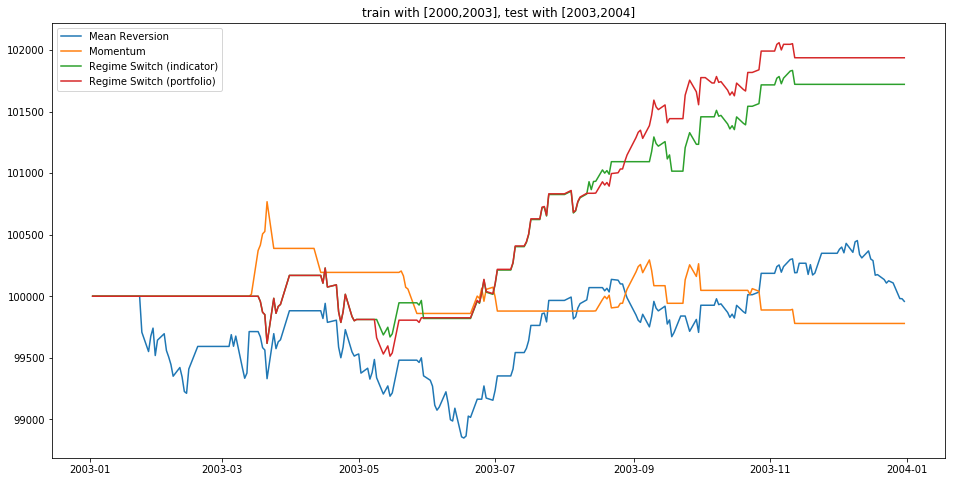

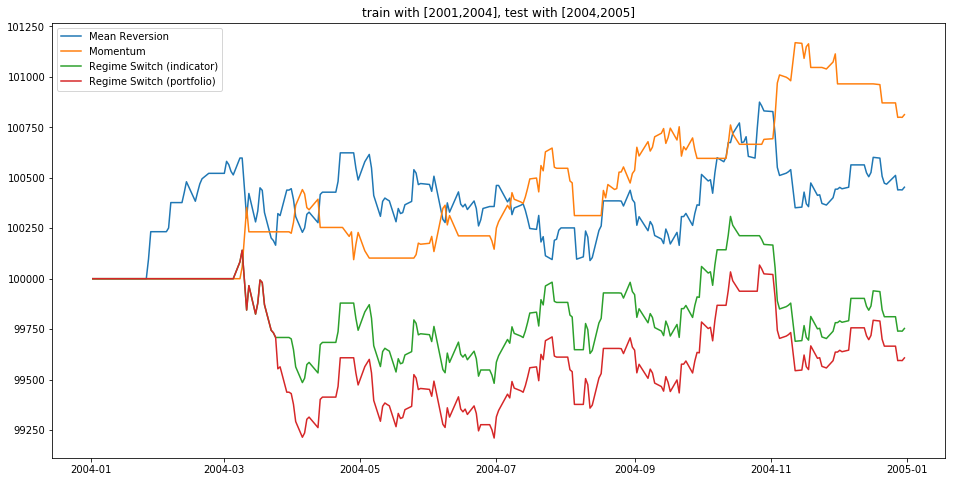

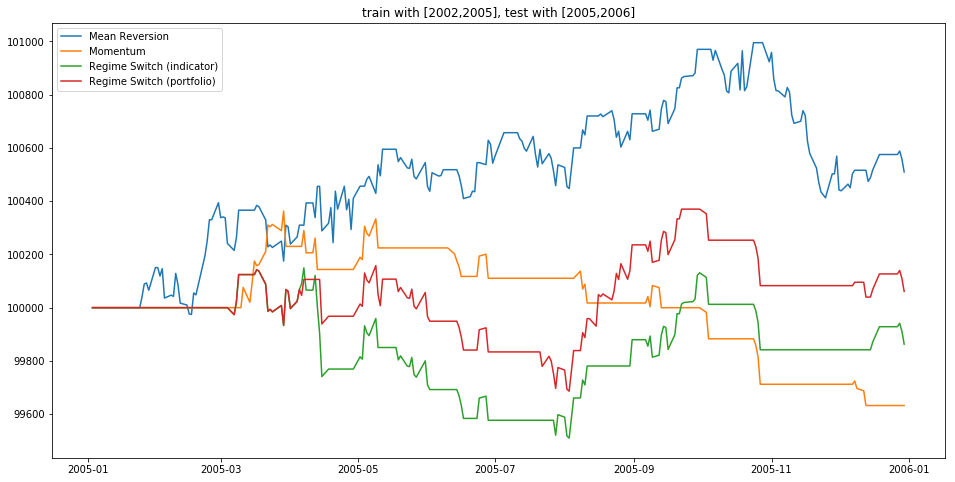

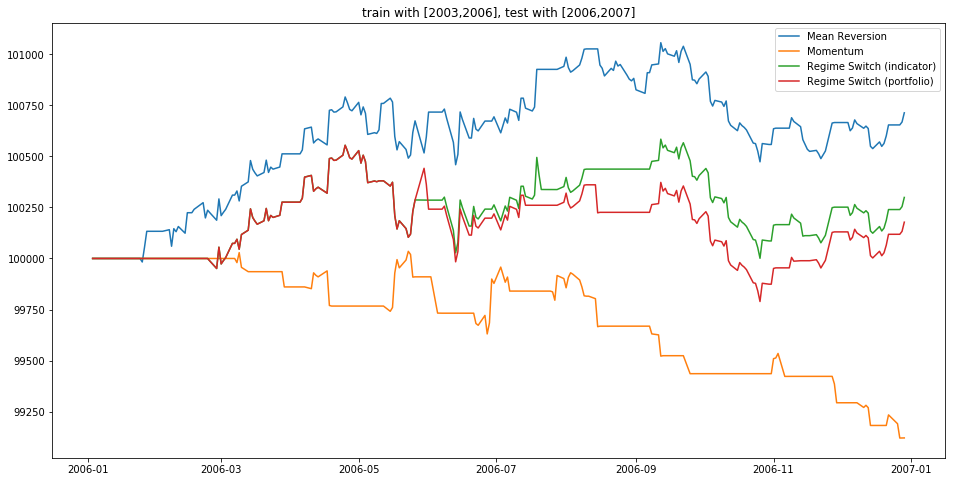

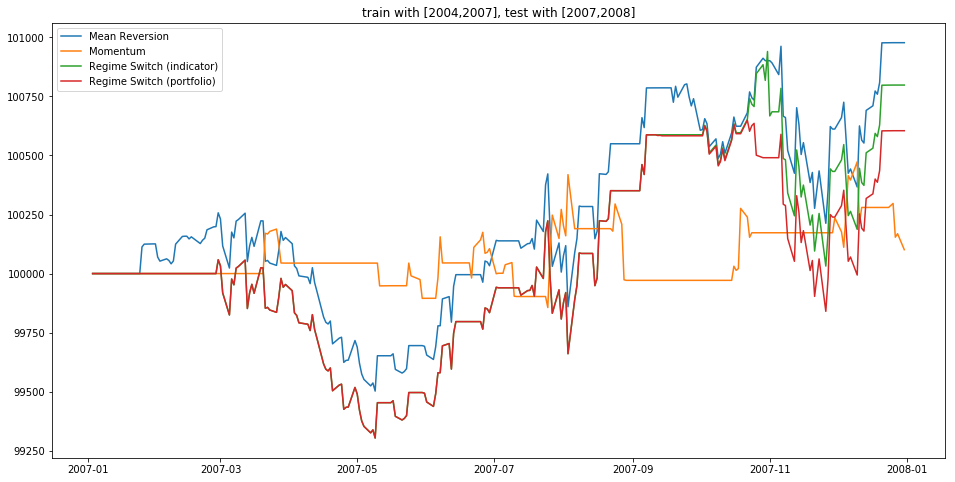

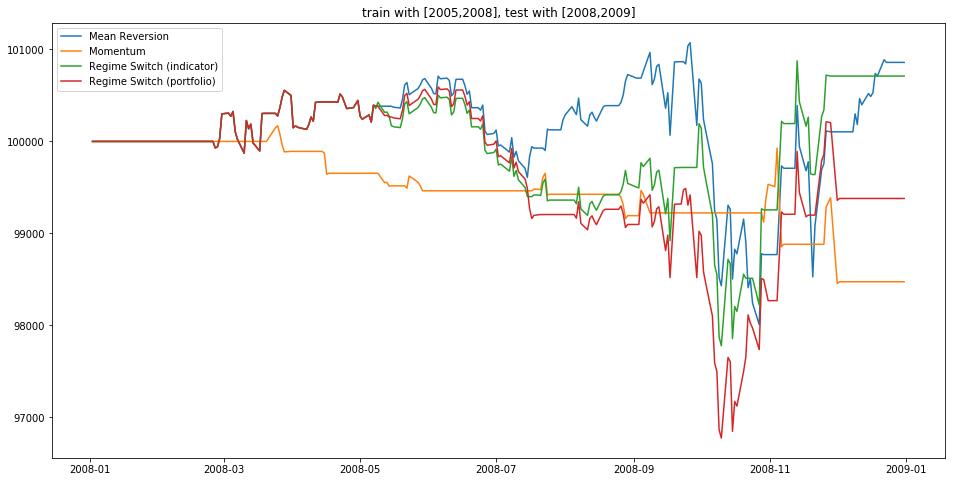

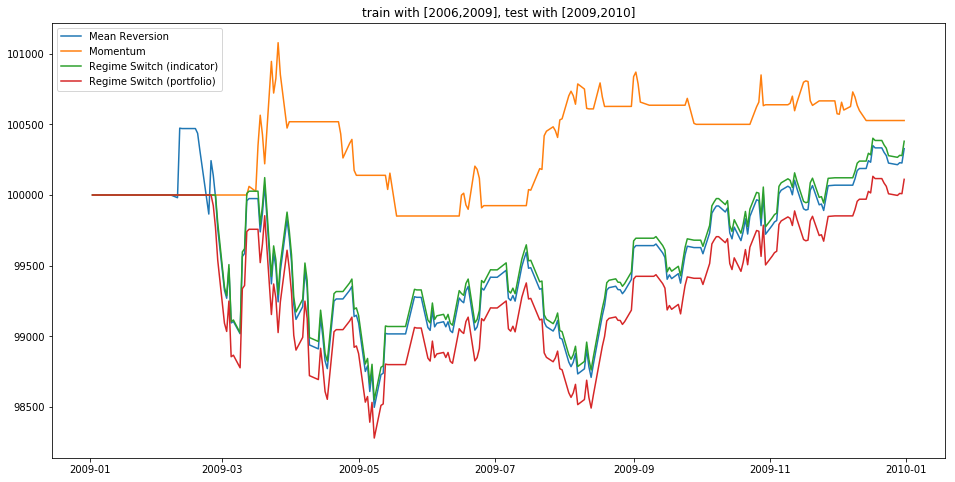

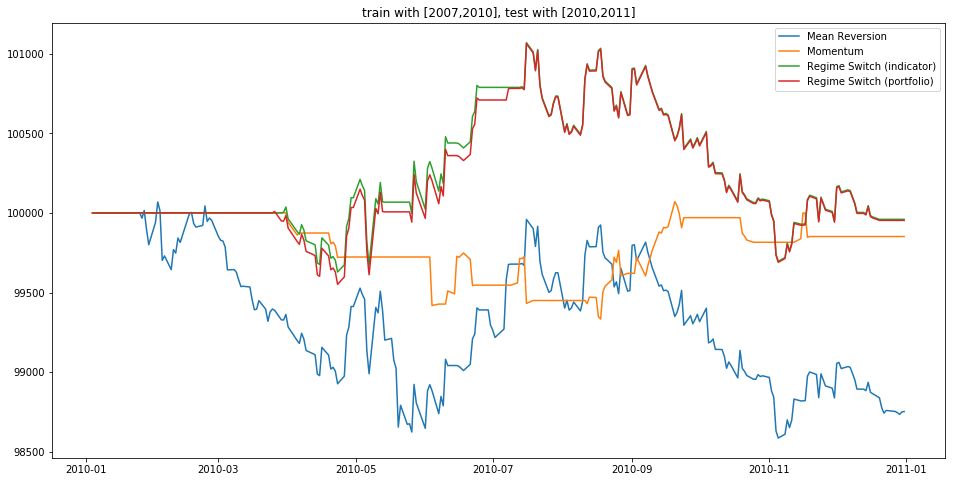

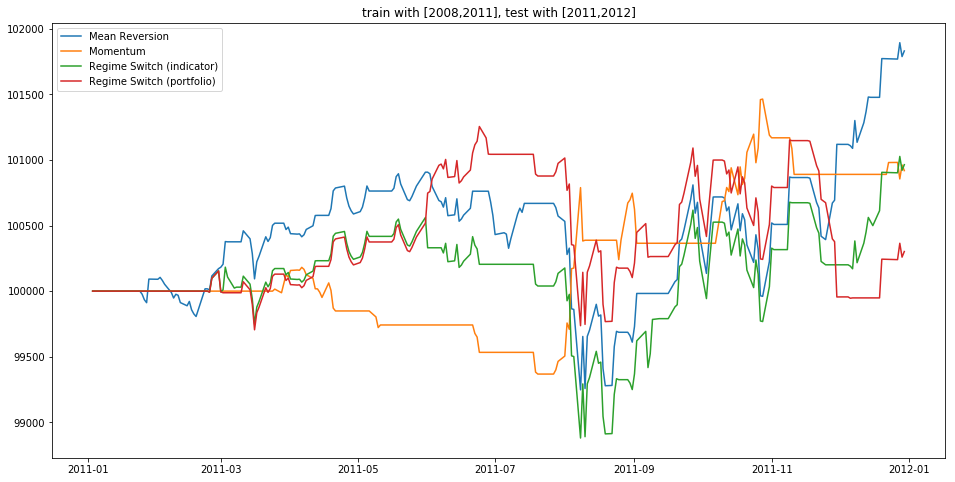

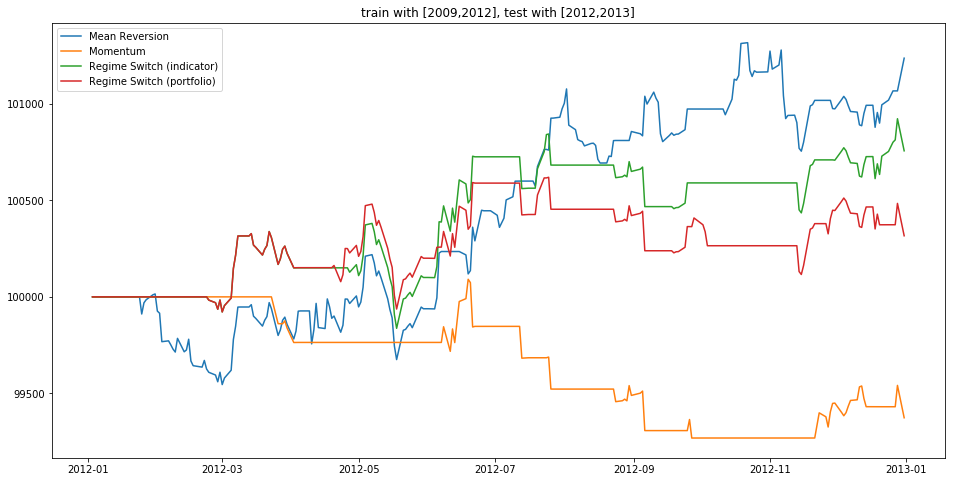

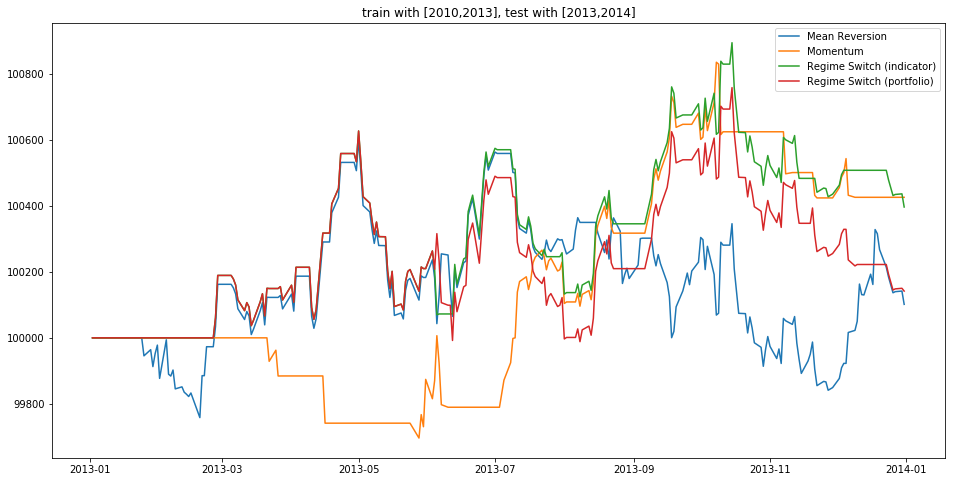

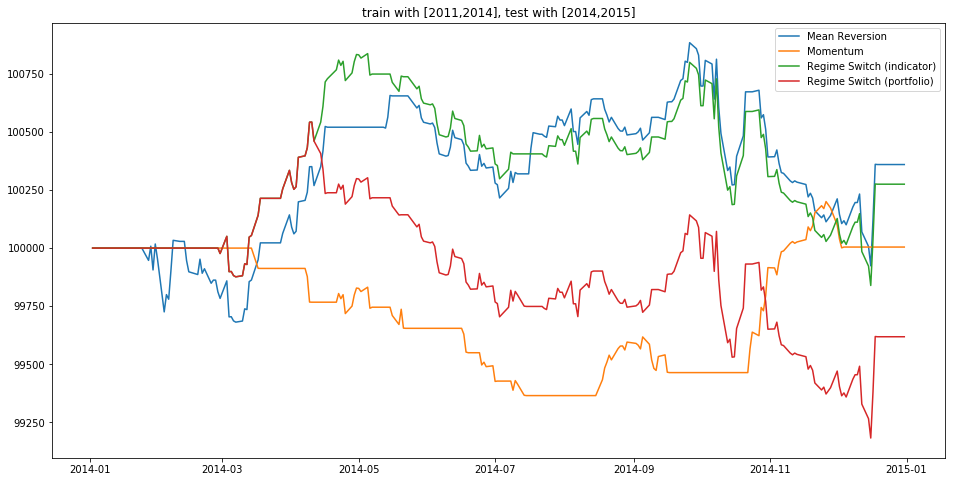

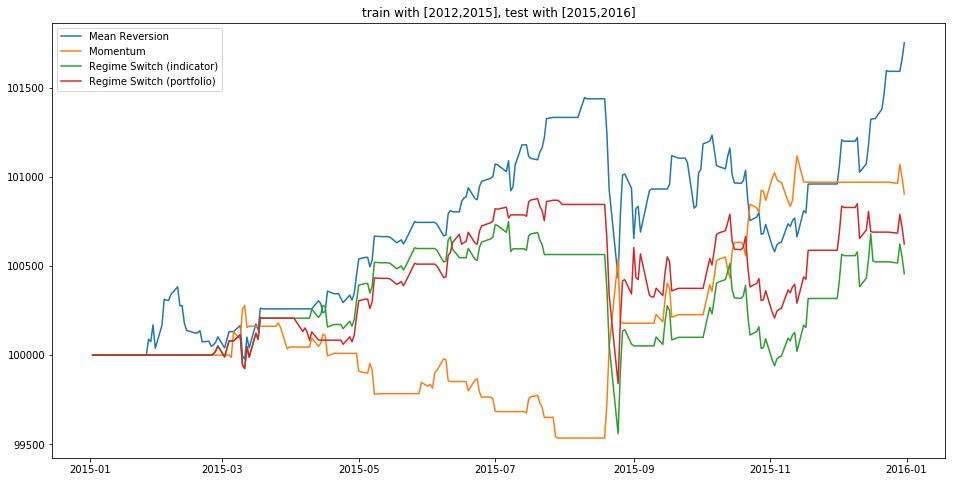

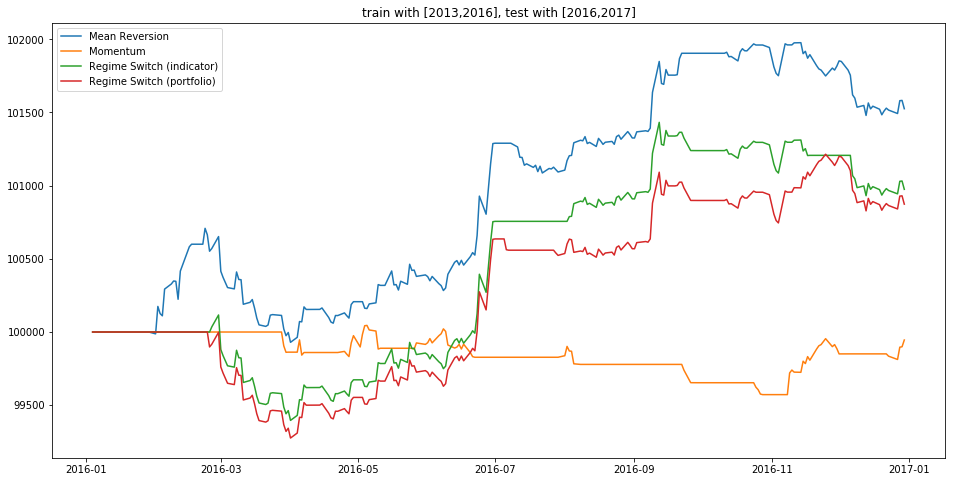

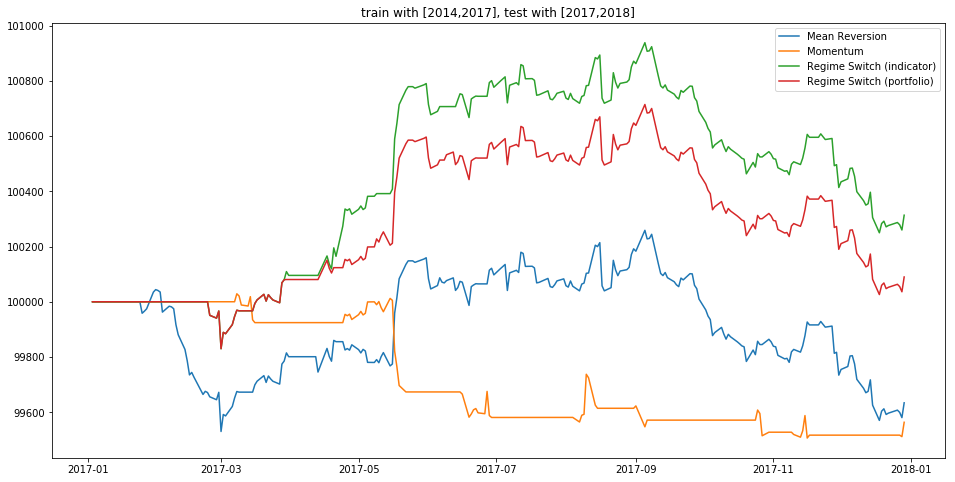

In [37]:
for i in range(15):
    start_year_train = 2000+i
    end_year_train = 2000+i+3
    start_year_test = 2000+i+3
    end_year_test = 2000+i+4
    # load data
    mr_value = get_value_curve("output/mr_%s_%s.csv"%(start_year_test,end_year_test))
    mo_value = get_value_curve("output/mo_%s_%s.csv"%(start_year_test,end_year_test))
    rs_i_value = get_value_curve("output/rs_i[%s,%s]_%s_%s.csv"%(start_year_train,end_year_train,start_year_test,end_year_test))
    rs_p_value = get_value_curve("output/rs_p[%s,%s]_%s_%s.csv"%(start_year_train,end_year_train,start_year_test,end_year_test))
    #plot
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(mr_value,label="Mean Reversion")
    ax.plot(mo_value,label="Momentum")
    ax.plot(rs_i_value,label="Regime Switch (indicator)")
    ax.plot(rs_p_value,label="Regime Switch (portfolio)")
    ax.legend()
    ax.set_title("train with [%s,%s], test with [%s,%s]"%(start_year_train,end_year_train,start_year_test,end_year_test))
    plt.savefig("output/curves/[%s,%s]train_[%s,%s]test.png"%(start_year_train,end_year_train,start_year_test,end_year_test))